## Предсказание запаса реактивности на основе изотопных составов топливных зон

In [35]:
# Импоортируем библиотеки
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import LinearSVR, SVR
import tensorflow as tf

In [2]:
# Считываем подготовленный csv
main_df = pd.read_csv('final.csv', sep=',', index_col=0 )

In [3]:
#Посмотрим на кол-во объектов и признаков
main_df.shape

(91, 172802)

Итого 91 различный вариант, помиотрим хватит ли такого кол-ва

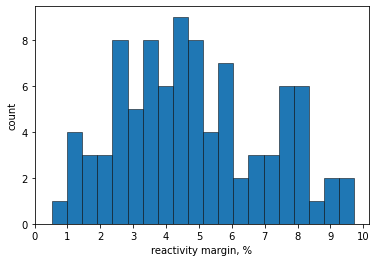

In [214]:
# Построим разброс значений целевой переменной
plt.hist(main_df.reactivity_margin, bins=20, linewidth=0.5, edgecolor="black")
plt.xlabel('reactivity margin, %')
plt.ylabel('count')
plt.xticks(list(range(11)))
plt.show()

В целом явно выпадающих значений нет, большая часть значений лежит от 3 до 5%, что соответствуеют типичному циклу работы реактора

In [215]:
# Поскольку реактивность зависит только от Кэф, удаляем данный столбец
main_df.drop(columns=['Keff'], inplace=True)
target = main_df.pop('reactivity_margin')
# Разделяем данные на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(main_df, target, test_size=0.3, random_state=7)
# Проверяем раззмерности обуч. и тест. наборов
X_train.shape, X_test.shape

((63, 172800), (28, 172800))

## Sklearn модели

In [4]:
# Для начала протестируем самую простую модель наименьших квадратов, а также три модели посложнее, линейную модель,
# которая минимизирует лосс с помощью стохастического градиентного спуска, линейную модель опорных векторов и модель опорных
# векторов с ядерным трюком. Для более сложных моделей будем подбирать оптимальный параметры с помощью HalvingGridSearch
lr = LinearRegression(n_jobs=-1)

sgd = SGDRegressor()

sgd_params = {
    'penalty':['l2', 'elasticnet'],
    'alpha':[0.0001, 0.001, 0.005],
    'l1_ratio':[0.15, 0.25, 0.5, 0.65, 0.75],
    'fit_intercept':[True],
    'tol':[0.0005],
    'max_iter':[50000]
}

lin_svr = LinearSVR()
             
lin_svr_params = {
    'tol':[0.0005],
    'C':[0.1, 0.5, 1, 10],
    'max_iter':[50000]
}

svr = SVR()

svr_params = {
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'tol': [0.0005], 
    'C': np.logspace(-3,2, 6),
    'max_iter': [-1]
}


In [5]:
# Поскольку решается задача регрессии, то для поиска параметров можно ограничиться обычной k-блочной перекрестной проверкой
sss = KFold(n_splits=3, shuffle=True, random_state=7)

In [218]:
%%time 
# Обучаем модели
lr.fit(X_train, y_train)

sgd_search = HalvingGridSearchCV(estimator=sgd, 
                                 param_grid=sgd_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=7,
                                 n_jobs=-1).fit(X_train, y_train)

lin_svr_search = HalvingGridSearchCV(estimator=lin_svr, 
                                     param_grid=lin_svr_params,
                                     scoring='r2',
                                     cv=sss, 
                                     random_state=7,
                                     n_jobs=-1).fit(X_train, y_train)

svr_search = HalvingGridSearchCV(estimator=svr, 
                                 param_grid=svr_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=7,
                                 n_jobs=-1).fit(X_train, y_train)


Wall time: 4min 29s


In [219]:
#Глядя на ошибку обычной линейной модели, можно сделать вывод, что данная модель для решения задачи не подходит
mean_absolute_error(y_test, lr.predict(X_test))

494.363415440665

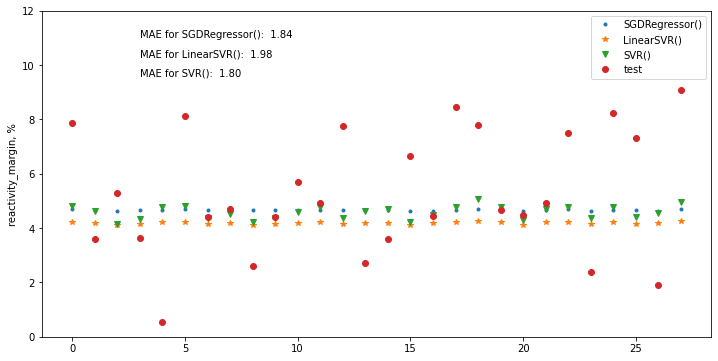

In [220]:
models = [sgd_search, lin_svr_search, svr_search]
markers = ['.', '*', 'v']
fig, ax = plt.subplots(figsize=(12,6))
for model, marker, y_text in zip(models, markers, [11,10.3,9.6]):
    y_pred = model.predict(X_test)
    ax.plot(y_pred, marker, label=(model.estimator))
    ax.text(s=f'MAE for {model.estimator}: {mean_absolute_error(y_test, y_pred): .2f}', x=3, y=y_text)
ax.plot([x for x in range(len(y_test))], y_test, 'o', label='test')
ax.set_ylabel('reactivity_margin, %')
ax.set_ylim(0, 12)
ax.legend()
plt.show()

## Вывод
Регрессионные модели способны предсказывать с довольно большой погрешностью, что может быть связано с влиянием различных ампульных устройств в отражателе, в особоенности ампулы в ячейке 6-4

In [2]:
# в файле final_with_ampules.csv помимо изотопных составов также имеется информация о ампуле в ячейке 6-4, которая
# уменьшает запас реактивности на порядка 2%. Это можно учесть просто вычев или прибавив данное значение, но 
# для начала можно попробовать учесть это простой индекацией наличия данной ампулы.
main_df2 = pd.read_csv('final_with_ampules.csv', sep=',', index_col=0 )

In [3]:
#Посчитаем кол-во вариантов с ампулой и без и соответствующие запасы
main_df2.groupby('ampule').agg({'Keff':'count', 'reactivity_margin':'mean'})

,Keff,reactivity_margin
ampule,,
0,22,4.867830
1,68,4.929305


In [4]:
main_df2.drop(columns=['Keff'], inplace=True)
target2 = main_df2.pop('reactivity_margin')

C:\Users\Anton\AppData\Local\Temp/ipykernel_1660/876083021.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_avg_conc[f'avg_c_in_{num_matr}_to_{num_matr+NUM_ZONES_PER_FE-1}_for_{nuclide}'] = main_df2.filter(items = [f'{nuclide} in mat{num}' for num in range(num_matr, num_matr+NUM_ZONES_PER_FE)], axis=1).apply(axis=1, func=np.mean)


,avg_c_in_15563_to_15922_for_u235,avg_c_in_15923_to_16282_for_u235,avg_c_in_16283_to_16642_for_u235,avg_c_in_16643_to_17002_for_u235,avg_c_in_17003_to_17362_for_u235,avg_c_in_17363_to_17722_for_u235,avg_c_in_17723_to_18082_for_u235,avg_c_in_18083_to_18442_for_u235,avg_c_in_18443_to_18802_for_u235,avg_c_in_18803_to_19162_for_u235,...,avg_c_in_46523_to_46882_for_sm49,avg_c_in_46883_to_47242_for_sm49,avg_c_in_47243_to_47602_for_sm49,avg_c_in_47603_to_47962_for_sm49,avg_c_in_47963_to_48322_for_sm49,avg_c_in_48323_to_48682_for_sm49,avg_c_in_48683_to_49042_for_sm49,avg_c_in_49043_to_49402_for_sm49,avg_c_in_49403_to_49762_for_sm49,avg_c_in_49763_to_50122_for_sm49
0,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
1,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
2,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
3,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
4,0.001120,0.001135,0.001143,0.001147,0.001144,0.001133,0.001621,0.001634,0.001642,0.001645,...,2.723002e-07,2.719446e-07,2.729689e-07,2.762814e-07,2.044777e-07,2.043944e-07,2.045678e-07,2.049895e-07,2.058990e-07,2.074468e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.001731,0.001722,0.001673,0.001698,0.001716,0.001658,0.001204,0.001213,0.001184,0.001196,...,1.744768e-07,1.783566e-07,1.800168e-07,1.748016e-07,2.180973e-07,2.163685e-07,2.088396e-07,2.135990e-07,2.138828e-07,2.135722e-07
86,0.001715,0.001707,0.001659,0.001683,0.001701,0.001643,0.001193,0.001202,0.001174,0.001185,...,1.161421e-07,1.186566e-07,1.191609e-07,1.144789e-07,1.565044e-07,1.568710e-07,1.521704e-07,1.559188e-07,1.555900e-07,1.537947e-07
87,0.001687,0.001680,0.001633,0.001657,0.001674,0.001617,0.001174,0.001184,0.001156,0.001166,...,1.221652e-07,1.249094e-07,1.258932e-07,1.217462e-07,1.599630e-07,1.594996e-07,1.543420e-07,1.579889e-07,1.578659e-07,1.567750e-07
88,0.001602,0.001598,0.001555,0.001579,0.001594,0.001537,0.001116,0.001126,0.001099,0.001109,...,2.226987e-07,2.278143e-07,2.309709e-07,2.263424e-07,2.657612e-07,2.612477e-07,2.510024e-07,2.562330e-07,2.571179e-07,2.585452e-07


In [5]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(main_df2, target2, test_size=0.2, random_state=7)

In [10]:
%%time
#В качестве первого шага применим аналогичные модели
sgd_search = HalvingGridSearchCV(estimator=sgd, 
                                 param_grid=sgd_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=9,
                                 n_jobs=-1).fit(X_train2, y_train2)

lin_svr_search = HalvingGridSearchCV(estimator=lin_svr, 
                                     param_grid=lin_svr_params,
                                     scoring='r2',
                                     cv=sss, 
                                     random_state=9,
                                     n_jobs=-1).fit(X_train2, y_train2)

svr_search = HalvingGridSearchCV(estimator=svr, 
                                 param_grid=svr_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=9,
                                 n_jobs=-1).fit(X_train2, y_train2)

Wall time: 6min 24s


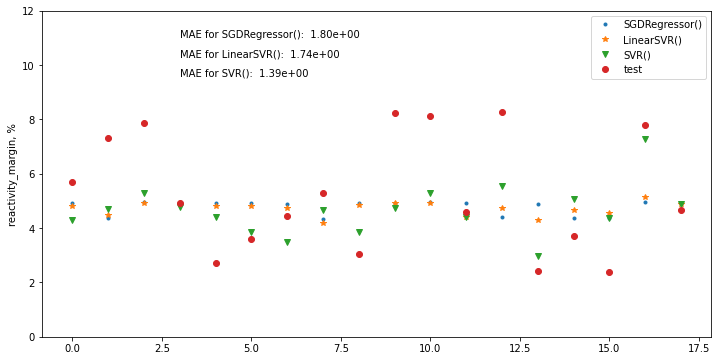

In [11]:
models = [sgd_search, lin_svr_search, svr_search]
markers = ['.', '*', 'v']
fig, ax = plt.subplots(figsize=(12,6))
for model, marker, y_text in zip(models, markers, [11,10.3,9.6]):
    y_pred = model.predict(X_test2)
    ax.plot(y_pred, marker, label=(model.estimator))
    ax.text(s=f'MAE for {model.estimator}: {mean_absolute_error(y_test2, y_pred): .2e}', x=3, y=y_text)
ax.plot([x for x in range(len(y_test2))], y_test2, 'o', label='test')
ax.set_ylabel('reactivity_margin, %')
ax.set_ylim(0, 12)
ax.legend()
plt.show()

## Вывод
Добавив 1 признак наличия ампулы к уже имеющимся **172800**, удалось **снизить** абсолютную ошибку с **2** до **1.4** <div>
**Наилучшей** моделью из рассмотренных оказалась **SVC**, что связано с большой нелинейностью зависимости целевой переменной от признаков

## Библиотека XGBoost + Optuna

In [36]:
# !pip install xgboost
# !pip install optuna
import xgboost as xgb
import optuna

In [9]:
def objective(trial, data=main_df2, label=target2):
    train_x, valid_x, train_y, valid_y = train_test_split(data, label, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 2,
        "objective": "reg:squarederror",
        "num_round": trial.suggest_int("num_round", 1000, 4000, step=500),
        # For larger dataset, approximate algorithm (approx) will be chosen.
        # Also it’s recommended to try hist and gpu_hist for higher performance with large dataset.
        "tree_method": "approx",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data. XGBoost would randomly sample half of the training data prior to growing trees
        # and this will prevent overfitting.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 2, 4, step=1)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    rmse = mean_squared_error(valid_y, preds, squared=False)
    return rmse

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300, timeout=None, n_jobs=3)

print("Number of finished trials: ", len(study.trials))
print(f"Best trial: {study.best_trial}") 

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-07 14:56:01,337] A new study created in memory with name: no-name-f73686d6-c19e-45a0-a444-e8ec0e43b58b
C:\Users\Anton\anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-07-07 14:56:24,870] Trial 0 finished with value: 2.430555282752741 and parameters: {'num_round': 1800, 'booster': 'gblinear', 'lambda': 8.227760886309509e-05, 'alpha': 0.0005691009810988934, 'subsample': 0.49651343391372627, 'colsample_bytree': 0.4376722526734275}. Best is trial 0 with value: 2.430555282752741.
[I 2022-07-07 14:56:36,377] Trial 2 finished with value: 5.236896119942323 and parameters: {'num_round': 1800, 'booster': 'gbtree', 'lambda': 0.043488084432377165, 'alpha': 5.076240052645602e-06, 'subsample': 0.7655432660452626, 'colsample_bytree': 0.9498836492494249, 'max_depth': 2, 'min_child_weight': 3, 'eta': 0

[I 2022-07-07 15:00:21,699] Trial 18 finished with value: 5.390367561014091 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 9.967687997076664e-08, 'alpha': 0.06811103086406933, 'subsample': 0.9958571487362718, 'colsample_bytree': 0.5108706472997259, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.0005843056713221172, 'gamma': 2.1581692598993987e-05, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 1.0113901692984892.
[I 2022-07-07 15:00:21,995] Trial 19 finished with value: 4.9187118444559035 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 3.3044484485748855e-08, 'alpha': 0.02621618880297237, 'subsample': 0.9676690745966772, 'colsample_bytree': 0.5391917491143224, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.00073317502029619, 'gamma': 2.4762463159503173e-05, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 1.0113901692984892.
[I 2022-07-07 15:00:26,096] Trial 20 finished with value: 5.268041688835375 and parameters: {'num_roun

[I 2022-07-07 15:06:37,595] Trial 35 finished with value: 1.3384715711936834 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 3.146244115275389e-05, 'alpha': 0.0012308000148380633, 'subsample': 0.6126090558827442, 'colsample_bytree': 0.3336802323208302, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.6644770282947552, 'gamma': 0.04585402413811472, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0029788770225999055, 'skip_drop': 1.1544550962501604e-08}. Best is trial 12 with value: 1.0113901692984892.
[I 2022-07-07 15:06:56,167] Trial 36 finished with value: 5.3268839392372485 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 5.634879768358497e-07, 'alpha': 1.3270940492993441e-05, 'subsample': 0.4688011395580942, 'colsample_bytree': 0.22332051432376548, 'max_depth': 4, 'min_child_weight': 10, 'eta': 4.983906419770144e-07, 'gamma': 0.001129720093503864, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'no

[I 2022-07-07 15:09:24,536] Trial 51 finished with value: 2.7229554535689062 and parameters: {'num_round': 1400, 'booster': 'dart', 'lambda': 1.4270712252836913e-08, 'alpha': 0.853230760538693, 'subsample': 0.23945152171561246, 'colsample_bytree': 0.4701140033147886, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.9951707474161858, 'gamma': 1.062450736752566e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00019025177638141438, 'skip_drop': 0.05163349254742995}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 15:10:09,675] Trial 52 finished with value: 1.0671565974842119 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 1.1737189306985906e-06, 'alpha': 0.015638439698865133, 'subsample': 0.7849548387283576, 'colsample_bytree': 0.40902438412852865, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.3543336837811939, 'gamma': 0.0048179076939517404, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normaliz

[I 2022-07-07 15:25:28,306] Trial 69 finished with value: 4.337536209157202 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 0.24453017370123636, 'alpha': 0.09352013493016875, 'subsample': 0.8767823291422302, 'colsample_bytree': 0.9987319583120113, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.020887156573176694, 'gamma': 0.060650834709808185, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.013402420076569265, 'skip_drop': 0.10669168908346881}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 15:25:28,368] Trial 67 finished with value: 4.938769699985421 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 0.0021958772887458833, 'alpha': 0.2941755343187844, 'subsample': 0.8567824578096948, 'colsample_bytree': 0.99451266460687, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.014996555320731866, 'gamma': 0.0004352672605138753, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type

[I 2022-07-07 16:36:57,270] Trial 83 finished with value: 1.5785141729367698 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 3.124474029746038e-06, 'alpha': 0.0015314525521278215, 'subsample': 0.9953524611504457, 'colsample_bytree': 0.6423257946145022, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.1068615778609044, 'gamma': 0.0008506055914695749, 'grow_policy': 'lossguide'}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 16:36:59,442] Trial 82 finished with value: 3.4562903622348764 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 7.0988396783169875e-06, 'alpha': 0.0017369197140864243, 'subsample': 0.9722486527914258, 'colsample_bytree': 0.629429403374727, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.03912074913873038, 'gamma': 0.008976841687640954, 'grow_policy': 'lossguide'}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 16:36:59,552] Trial 84 finished with value: 2.009422917499417 and parameters: {'num_round'

[I 2022-07-07 17:05:28,557] Trial 99 finished with value: 2.1993361561082274 and parameters: {'num_round': 1400, 'booster': 'gblinear', 'lambda': 2.0603462728121785e-08, 'alpha': 0.16931994429517924, 'subsample': 0.8622841579641364, 'colsample_bytree': 0.5618767320681476}. Best is trial 88 with value: 0.8877407743952134.
[I 2022-07-07 17:05:28,635] Trial 98 finished with value: 1.3947406837501617 and parameters: {'num_round': 1400, 'booster': 'gblinear', 'lambda': 4.6728464159812754e-07, 'alpha': 3.139289403673577e-06, 'subsample': 0.8656294875629816, 'colsample_bytree': 0.5535651471185415}. Best is trial 88 with value: 0.8877407743952134.
[I 2022-07-07 17:07:25,541] Trial 102 finished with value: 3.393345311944049 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 6.393780020497667e-07, 'alpha': 3.985650167612618e-08, 'subsample': 0.7740739661592447, 'colsample_bytree': 0.663655078103167, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.05063542685911479, 'gamma': 0.04111

[I 2022-07-07 17:11:10,220] Trial 114 finished with value: 1.3160485491357572 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 5.4592698581514695e-08, 'alpha': 0.024267542438143063, 'subsample': 0.6015700578991919, 'colsample_bytree': 0.24299988414930815, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.6005672229746578, 'gamma': 0.031277972326379654, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.10300946490748085, 'skip_drop': 0.5447220583184671}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:11:10,938] Trial 112 finished with value: 1.0780924470980557 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 5.4281969083636526e-08, 'alpha': 0.021163418583992795, 'subsample': 0.6349590178198317, 'colsample_bytree': 0.391251761659751, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.6725476875766118, 'gamma': 0.0005575373806224553, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normaliz

[I 2022-07-07 17:15:17,406] Trial 128 finished with value: 2.5155980169761896 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 8.95455146943706e-07, 'alpha': 0.23026912441752817, 'subsample': 0.7325719731281635, 'colsample_bytree': 0.36263841119041373, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.07134232671614706, 'gamma': 0.004040671022571215, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0001225733218382395, 'skip_drop': 0.01910386017241191}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:15:19,702] Trial 130 finished with value: 1.470190229519847 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 1.1743408054876079e-06, 'alpha': 0.03454210446299013, 'subsample': 0.5413430091298302, 'colsample_bytree': 0.35629328887667316, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.18324379108817532, 'gamma': 0.1567599566621204, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize

[I 2022-07-07 17:22:32,061] Trial 145 finished with value: 1.1698020504740934 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 3.6158138168644865e-07, 'alpha': 0.0170718001405816, 'subsample': 0.8964760958789589, 'colsample_bytree': 0.288392435280711, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.8810792232434103, 'gamma': 0.012289905850100778, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0031748839768481283, 'skip_drop': 0.042751897992318974}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:22:32,108] Trial 143 finished with value: 1.098502758191897 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 4.02294602661843e-07, 'alpha': 0.01888127654131026, 'subsample': 0.895578704858783, 'colsample_bytree': 0.2531820699806269, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.9513426058646318, 'gamma': 0.011409680983737626, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_typ

[I 2022-07-07 17:26:02,869] Trial 159 finished with value: 2.048116957147524 and parameters: {'num_round': 1800, 'booster': 'gblinear', 'lambda': 9.13268574273984e-08, 'alpha': 0.028987539736236998, 'subsample': 0.707720479393189, 'colsample_bytree': 0.37051137024658637}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:26:04,866] Trial 160 finished with value: 1.860264137527366 and parameters: {'num_round': 1800, 'booster': 'gblinear', 'lambda': 3.928619566890204e-08, 'alpha': 0.02949847997993717, 'subsample': 0.7037049362090005, 'colsample_bytree': 0.40886628773248435}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:26:09,631] Trial 158 finished with value: 0.9473709440505679 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 2.940363680967826e-07, 'alpha': 0.02752516867990664, 'subsample': 0.851698707233464, 'colsample_bytree': 0.3748799020165568, 'max_depth': 2, 'min_child_weight': 10, 'eta': 0.6984984988185665, 'gamma': 0.0153293

[I 2022-07-07 17:28:46,634] Trial 173 finished with value: 0.8965075692077129 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 1.1797143300861065e-07, 'alpha': 0.03309996897703381, 'subsample': 0.8742891315484451, 'colsample_bytree': 0.37857157903171434, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.654243614700289, 'gamma': 0.012960914614934609, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.08844290281796843, 'skip_drop': 0.9444894725473495}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:29:00,119] Trial 175 finished with value: 1.3435422543552495 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 1.3485283577832868e-07, 'alpha': 0.03549020956458979, 'subsample': 0.6621119015274146, 'colsample_bytree': 0.3564381288502467, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.45529561632919896, 'gamma': 0.10390373390133761, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_t

In [52]:
#Рассмотрение концентрации в каждой зоне объема весьма затратно, поэтому создидим новый df с усредненными по твэлам концентрациями
NUM_ZONES_PER_FE = 360
df_avg_conc = pd.DataFrame()
for nuclide in ['u235', 'u238', 'pu39', 'xe35', 'sm49']:
    for num_matr in range(15563, 50123, NUM_ZONES_PER_FE):
        df_avg_conc[f'avg_c_in_{num_matr}_to_{num_matr+NUM_ZONES_PER_FE-1}_for_{nuclide}'] = main_df2.filter(items = [f'{nuclide} in mat{num}' for num in range(num_matr, num_matr+NUM_ZONES_PER_FE)], axis=1).apply(axis=1, func=np.mean)
df_avg_conc['ampule'] = main_df2.ampule
df_avg_conc.sample(5)

C:\Users\Anton\AppData\Local\Temp/ipykernel_1660/2670308527.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_avg_conc[f'avg_c_in_{num_matr}_to_{num_matr+NUM_ZONES_PER_FE-1}_for_{nuclide}'] = main_df2.filter(items = [f'{nuclide} in mat{num}' for num in range(num_matr, num_matr+NUM_ZONES_PER_FE)], axis=1).apply(axis=1, func=np.mean)
C:\Users\Anton\AppData\Local\Temp/ipykernel_1660/2670308527.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_avg_conc['ampule'] = main_df2.ampule


,avg_c_in_15563_to_15922_for_u235,avg_c_in_15923_to_16282_for_u235,avg_c_in_16283_to_16642_for_u235,avg_c_in_16643_to_17002_for_u235,avg_c_in_17003_to_17362_for_u235,avg_c_in_17363_to_17722_for_u235,avg_c_in_17723_to_18082_for_u235,avg_c_in_18083_to_18442_for_u235,avg_c_in_18443_to_18802_for_u235,avg_c_in_18803_to_19162_for_u235,...,avg_c_in_46883_to_47242_for_sm49,avg_c_in_47243_to_47602_for_sm49,avg_c_in_47603_to_47962_for_sm49,avg_c_in_47963_to_48322_for_sm49,avg_c_in_48323_to_48682_for_sm49,avg_c_in_48683_to_49042_for_sm49,avg_c_in_49043_to_49402_for_sm49,avg_c_in_49403_to_49762_for_sm49,avg_c_in_49763_to_50122_for_sm49,ampule
14,0.001305,0.001330,0.001344,0.001350,0.001346,0.001328,0.001201,0.001212,0.001215,0.001210,...,1.688385e-07,1.709734e-07,1.628384e-07,1.463107e-07,1.470543e-07,1.474290e-07,1.473954e-07,1.471001e-07,1.464951e-07,1
72,0.001739,0.001805,0.001772,0.001811,0.001763,0.001742,0.001124,0.001116,0.001103,0.001123,...,1.838311e-07,1.864082e-07,1.833515e-07,1.671817e-07,1.663446e-07,1.623331e-07,1.647999e-07,1.667294e-07,1.624078e-07,1
56,0.001927,0.001990,0.001948,0.001989,0.001938,0.001921,0.001102,0.001102,0.001086,0.001085,...,2.508382e-07,2.523008e-07,2.479736e-07,3.010183e-07,2.939193e-07,2.840746e-07,2.874756e-07,2.923675e-07,2.899926e-07,1
40,0.001406,0.001399,0.001374,0.001399,0.001409,0.001353,0.001358,0.001341,0.001281,0.001305,...,2.217732e-07,2.225441e-07,2.183250e-07,1.232251e-08,1.152952e-08,1.088173e-08,1.088369e-08,1.111445e-08,1.132662e-08,0
38,0.001488,0.001479,0.001451,0.001478,0.001489,0.001432,0.001437,0.001417,0.001353,0.001379,...,3.387928e-07,3.410156e-07,3.386492e-07,2.458252e-07,2.477538e-07,2.492566e-07,2.504016e-07,2.512250e-07,2.518468e-07,0


In [54]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(df_avg_conc, target2, test_size=0.2, random_state=7)

In [55]:
def objective(trial, data=X_train3, label=y_train3):
    train_x, valid_x, train_y, valid_y = train_test_split(data, label, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 1,
        "objective": "reg:squarederror",
        "num_round": trial.suggest_int("num_round", 3000, 30000, step=1000),
        # For larger dataset, approximate algorithm (approx) will be chosen.
        # Also it’s recommended to try hist and gpu_hist for higher performance with large dataset.
        "tree_method": trial.suggest_categorical("tree_method",["approx", "hist"]),
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
        # sampling ratio for training data. XGBoost would randomly sample half of the training data prior to growing trees
        # and this will prevent overfitting.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 2, 20, step=1)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    rmse = mean_squared_error(valid_y, preds, squared=False)
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=2000, timeout=None, n_jobs=3)

print("Number of finished trials: ", len(study.trials))
trial=study.best_trial
print(f"Best trial: {trial}") 

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-11 17:06:12,303] A new study created in memory with name: no-name-6ae8ce8a-2c53-43c8-96e0-23737b5bbb2d
C:\Users\Anton\anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-07-11 17:06:12,418] Trial 1 finished with value: 2.520488621038947 and parameters: {'num_round': 29000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 0.0022664487056804124, 'alpha': 7.5439487159681e-06, 'subsample': 0.33384080722176335, 'colsample_bytree': 0.7395246665895614}. Best is trial 1 with value: 2.520488621038947.
[I 2022-07-11 17:06:12,451] Trial 0 finished with value: 3.487451640113979 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.062370828683695444, 'alpha': 9.47928751596546e-06, 'subsample': 0.649501971703516, 'colsample_bytree': 0.721811837006215, 'm

[I 2022-07-11 17:06:13,201] Trial 18 finished with value: 4.560626246508375 and parameters: {'num_round': 11000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.8192769662546014e-08, 'alpha': 0.1831469423463116, 'subsample': 0.5513498885569083, 'colsample_bytree': 0.5266022661191678, 'max_depth': 20, 'min_child_weight': 5, 'eta': 1.6971750338449362e-07, 'gamma': 1.2553581671234892e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.590722012989451e-08, 'skip_drop': 3.865852465989064e-08}. Best is trial 3 with value: 1.770539850536098.
[I 2022-07-11 17:06:13,262] Trial 19 finished with value: 1.9249968630040553 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 9.188104161371283e-08, 'alpha': 0.23722753862195578, 'subsample': 0.573938255228833, 'colsample_bytree': 0.5542428303031317}. Best is trial 3 with value: 1.770539850536098.
[I 2022-07-11 17:06:13,349] Trial 21 finished with value: 2.

[I 2022-07-11 17:06:14,518] Trial 34 finished with value: 1.3203391154211697 and parameters: {'num_round': 28000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 6.134343892246763e-08, 'alpha': 5.0460318761592335e-08, 'subsample': 0.8465108967647427, 'colsample_bytree': 0.7272944002899623, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.5790927635351694, 'gamma': 0.00027488735924478694, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.08328698061301455, 'skip_drop': 0.14302932521577852}. Best is trial 33 with value: 1.2574801769297579.
[I 2022-07-11 17:06:14,524] Trial 35 finished with value: 1.4160182572815156 and parameters: {'num_round': 28000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 6.767721894835688e-08, 'alpha': 1.2362653926633445e-05, 'subsample': 0.6698162041324351, 'colsample_bytree': 0.7317459256576203, 'max_depth': 17, 'min_child_weight': 6, 'eta': 0.8707216159729628, 'gamma': 0.00012221596406898302, 'grow

[I 2022-07-11 17:06:15,644] Trial 51 finished with value: 4.778962175978183 and parameters: {'num_round': 8000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.004832661538416742, 'alpha': 2.083971425360846, 'subsample': 0.8876015713914136, 'colsample_bytree': 0.7670504353642121, 'max_depth': 18, 'min_child_weight': 5, 'eta': 2.480909045502937e-05, 'gamma': 0.0022839518548226118, 'grow_policy': 'depthwise'}. Best is trial 43 with value: 1.1705721331882295.
[I 2022-07-11 17:06:15,689] Trial 49 finished with value: 5.083244901429882 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.473062714873987e-06, 'alpha': 0.030256155313091018, 'subsample': 0.8875196193659459, 'colsample_bytree': 0.5769446808618173, 'max_depth': 10, 'min_child_weight': 5, 'eta': 2.1585380894735045e-05, 'gamma': 0.0015394233204959324, 'grow_policy': 'depthwise'}. Best is trial 43 with value: 1.1705721331882295.
[I 2022-07-11 17:06:15,818] Trial 53 finished with v

[I 2022-07-11 17:06:17,064] Trial 67 finished with value: 1.9943853337991342 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0015082506525742026, 'alpha': 0.0001561552587273888, 'subsample': 0.9412251586816388, 'colsample_bytree': 0.5874922157403335, 'max_depth': 14, 'min_child_weight': 5, 'eta': 0.10937529815223339, 'gamma': 0.08421761122657903, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 1.052125226569004.
[I 2022-07-11 17:06:17,108] Trial 68 finished with value: 2.6730885819818275 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.001821552369640485, 'alpha': 6.573471178319493e-05, 'subsample': 0.9393254955252257, 'colsample_bytree': 0.5790252055959589, 'max_depth': 14, 'min_child_weight': 5, 'eta': 0.10343455331421446, 'gamma': 0.09133301440900561, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 1.052125226569004.
[I 2022-07-11 17:06:17,207] Trial 69 finished with valu

[I 2022-07-11 17:06:18,224] Trial 84 finished with value: 1.3073242039973663 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0034336747295869944, 'alpha': 0.0001237079387439247, 'subsample': 0.8728609849182821, 'colsample_bytree': 0.9546636344862526, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.613949461435927, 'gamma': 0.2626268620697606, 'grow_policy': 'lossguide'}. Best is trial 72 with value: 0.8583271561618216.
[I 2022-07-11 17:06:18,324] Trial 85 finished with value: 2.5679513774728147 and parameters: {'num_round': 6000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 0.00036154029436179014, 'alpha': 0.00023957211468977272, 'subsample': 0.9273475038653023, 'colsample_bytree': 0.9921485102719724}. Best is trial 72 with value: 0.8583271561618216.
[I 2022-07-11 17:06:18,344] Trial 86 finished with value: 2.196046679013809 and parameters: {'num_round': 12000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 0.000148150276

[I 2022-07-11 17:06:19,490] Trial 102 finished with value: 1.2861268951791114 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0004046936717047659, 'alpha': 0.00022032779370109344, 'subsample': 0.8273336879888252, 'colsample_bytree': 0.4376743093334585, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.2441665967335569, 'gamma': 0.3353728821345913, 'grow_policy': 'lossguide'}. Best is trial 72 with value: 0.8583271561618216.
[I 2022-07-11 17:06:19,498] Trial 103 finished with value: 1.114625918232546 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0002055462293258261, 'alpha': 0.00020227553306365983, 'subsample': 0.8304963462783699, 'colsample_bytree': 0.8166879958412419, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.27969128085389167, 'gamma': 0.05867695719867208, 'grow_policy': 'lossguide'}. Best is trial 72 with value: 0.8583271561618216.
[I 2022-07-11 17:06:19,618] Trial 104 finished with v

[I 2022-07-11 17:06:20,704] Trial 119 finished with value: 0.834635154845597 and parameters: {'num_round': 9000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0003456294047791316, 'alpha': 5.60593764690705e-05, 'subsample': 0.9977179141198105, 'colsample_bytree': 0.8056993464736549, 'max_depth': 8, 'min_child_weight': 7, 'eta': 0.3292666364993923, 'gamma': 0.010661521877099983, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:20,804] Trial 120 finished with value: 1.3089427445047164 and parameters: {'num_round': 9000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0003888914728094977, 'alpha': 0.0001988841185252282, 'subsample': 0.9351218505688844, 'colsample_bytree': 0.8432332479776175, 'max_depth': 10, 'min_child_weight': 5, 'eta': 0.5008139286915986, 'gamma': 0.06642346700292441, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:20,854] Trial 121 finished with valu

[I 2022-07-11 17:06:21,925] Trial 136 finished with value: 5.361113298607555 and parameters: {'num_round': 11000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.000930826018694477, 'alpha': 0.6286043045938734, 'subsample': 0.9634988270597399, 'colsample_bytree': 0.979363181317661, 'max_depth': 7, 'min_child_weight': 9, 'eta': 9.097183804559904e-05, 'gamma': 0.014147136706210381, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:21,954] Trial 138 finished with value: 2.3920285101408663 and parameters: {'num_round': 11000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0008149755475911235, 'alpha': 27.58191787768607, 'subsample': 0.9649321539244047, 'colsample_bytree': 0.9770681623060826, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.5065868391839361, 'gamma': 0.02549586463203664, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:22,119] Trial 139 finished with value: 1.295

[I 2022-07-11 17:06:23,220] Trial 154 finished with value: 1.4149605755747476 and parameters: {'num_round': 17000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0014086861053813347, 'alpha': 8.995718720648756e-05, 'subsample': 0.9571187206217757, 'colsample_bytree': 0.46787564996119296, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.2963937142021355, 'gamma': 0.051386867176398794, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:23,330] Trial 155 finished with value: 1.1856442014688422 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.0070231881984777e-05, 'alpha': 0.00012741524860693495, 'subsample': 0.9999438178012896, 'colsample_bytree': 0.45588007801569197, 'max_depth': 10, 'min_child_weight': 6, 'eta': 0.3085856878244253, 'gamma': 7.306911084805982e-06, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:23,404] Trial 156 finished

[I 2022-07-11 17:06:24,431] Trial 171 finished with value: 1.3177593109780643 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0002944918458215364, 'alpha': 0.00016854180767152813, 'subsample': 0.9630537235997567, 'colsample_bytree': 0.7610230249426945, 'max_depth': 15, 'min_child_weight': 7, 'eta': 0.9819961409554492, 'gamma': 0.6008792295760206, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:24,617] Trial 172 finished with value: 1.2994756575124884 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.3958930160132802e-05, 'alpha': 0.0004220116700585761, 'subsample': 0.9837263217749352, 'colsample_bytree': 0.8220602786573293, 'max_depth': 12, 'min_child_weight': 6, 'eta': 0.4126189454828872, 'gamma': 0.00010203912536655479, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:24,690] Trial 174 finished w

[I 2022-07-11 17:06:25,838] Trial 188 finished with value: 1.6895376212993638 and parameters: {'num_round': 13000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00012522502919266152, 'alpha': 0.00014981834495360772, 'subsample': 0.9476187553714926, 'colsample_bytree': 0.9075012745899749, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.359617638065547, 'gamma': 0.1791997566185103, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:25,873] Trial 189 finished with value: 1.513550566125091 and parameters: {'num_round': 13000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00010135712483256192, 'alpha': 0.00014994820058032544, 'subsample': 0.917928464378474, 'colsample_bytree': 0.897360706474282, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.3544298842511917, 'gamma': 0.0038890800178576035, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:25,914] Trial 190 finished with value

[I 2022-07-11 17:06:27,207] Trial 206 finished with value: 1.7252145578314153 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00027418876352875967, 'alpha': 0.00010885277679497843, 'subsample': 0.9154827368266301, 'colsample_bytree': 0.7740061537194247, 'max_depth': 10, 'min_child_weight': 6, 'eta': 0.6001658522748105, 'gamma': 0.15099775699191567, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:27,240] Trial 207 finished with value: 1.3133581712967073 and parameters: {'num_round': 17000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00030040768958093325, 'alpha': 0.00010913499099588826, 'subsample': 0.9112025145410705, 'colsample_bytree': 0.7687803861787342, 'max_depth': 10, 'min_child_weight': 6, 'eta': 0.6702399772208888, 'gamma': 0.022167136088680952, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:27,351] Trial 208 finished 

[I 2022-07-11 17:06:28,583] Trial 224 finished with value: 0.9749094265350192 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00042067195797774673, 'alpha': 0.00022474941634759743, 'subsample': 0.9486972701386396, 'colsample_bytree': 0.9652740868066985, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.244492268389567, 'gamma': 0.005470618618130672, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:28,590] Trial 223 finished with value: 1.0528329137411212 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0003472801028035688, 'alpha': 0.00023201891313769064, 'subsample': 0.9594000426268452, 'colsample_bytree': 0.6780300494802571, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.18607001971606402, 'gamma': 0.0069219370394184646, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:28,798] Trial 225 finished w

[I 2022-07-11 17:06:30,028] Trial 240 finished with value: 5.026893262193447 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0003477786451402503, 'alpha': 0.00015817231274643128, 'subsample': 0.9008804169417594, 'colsample_bytree': 0.3687474329087318, 'max_depth': 8, 'min_child_weight': 6, 'eta': 0.0016973109606825555, 'gamma': 0.4204268375611857, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.947527274564736e-06, 'skip_drop': 4.092904933152048e-07}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:30,154] Trial 241 finished with value: 1.5001689199784791 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00036858871874903754, 'alpha': 0.00019297940387360822, 'subsample': 0.9848203250832298, 'colsample_bytree': 0.8202747548544085, 'max_depth': 10, 'min_child_weight': 6, 'eta': 0.5928272496931112, 'gamma': 0.020942172903607767, 'grow_

[I 2022-07-11 17:06:31,453] Trial 257 finished with value: 1.497720502367183 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0001575767116575612, 'alpha': 1.5351314582208586e-05, 'subsample': 0.9398672588406687, 'colsample_bytree': 0.709173901789563, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.3626933226330479, 'gamma': 0.04606424979484105, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:31,702] Trial 260 finished with value: 1.85496347951469 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 0.0002916998041936025, 'alpha': 5.051611320330898e-05, 'subsample': 0.9868199283947379, 'colsample_bytree': 0.6390940645900375}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:31,947] Trial 258 finished with value: 1.660185850595831 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0017209

[I 2022-07-11 17:06:33,402] Trial 275 finished with value: 1.4143990929202295 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00046200219495405283, 'alpha': 2.4165961127502523e-05, 'subsample': 0.9487012404055783, 'colsample_bytree': 0.9971527101965855, 'max_depth': 16, 'min_child_weight': 7, 'eta': 0.16355662582191405, 'gamma': 0.01507899084180415, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:33,488] Trial 276 finished with value: 2.4659423490519243 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.002081649957460151, 'alpha': 3.347157226153432e-05, 'subsample': 0.8382475221504003, 'colsample_bytree': 0.7902348898932723, 'max_depth': 16, 'min_child_weight': 7, 'eta': 0.08899040642603623, 'gamma': 0.01528399893221783, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:33,506] Trial 277 finished wi

[I 2022-07-11 17:06:34,898] Trial 293 finished with value: 1.6641980889035082 and parameters: {'num_round': 27000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00408961102336583, 'alpha': 8.413356183671738e-05, 'subsample': 0.9525445813656868, 'colsample_bytree': 0.8551968850698958, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.9624552245544103, 'gamma': 0.00538431210507787, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:34,974] Trial 294 finished with value: 1.4823235103298644 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00030595153722633774, 'alpha': 0.00034239095069101103, 'subsample': 0.9521122091181906, 'colsample_bytree': 0.8452602839493487, 'max_depth': 10, 'min_child_weight': 6, 'eta': 0.34522033601903374, 'gamma': 0.005104518204245066, 'grow_policy': 'lossguide'}. Best is trial 119 with value: 0.834635154845597.
[I 2022-07-11 17:06:35,013] Trial 295 finished wit

[I 2022-07-11 17:06:36,488] Trial 310 finished with value: 1.4120874676368886 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 9.357519364326204e-05, 'alpha': 0.00011365428432044977, 'subsample': 0.937880321736143, 'colsample_bytree': 0.7575957926101439, 'max_depth': 11, 'min_child_weight': 7, 'eta': 0.16545801095344878, 'gamma': 0.024962157187392427, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.6717985291440456e-07, 'skip_drop': 4.327097568529307e-05}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:36,545] Trial 311 finished with value: 1.169511887395789 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0002047699291149514, 'alpha': 0.00010329332874784721, 'subsample': 0.9373138812182089, 'colsample_bytree': 0.7340699114070366, 'max_depth': 11, 'min_child_weight': 7, 'eta': 0.2317867375145769, 'gamma': 0.0213727947379423, 'grow

[I 2022-07-11 17:06:37,977] Trial 327 finished with value: 1.216031615147555 and parameters: {'num_round': 8000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0001231328023814573, 'alpha': 0.0007353400734308186, 'subsample': 0.6341845817298715, 'colsample_bytree': 0.8434789115122348, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.28187440749929865, 'gamma': 2.5653653669996725e-06, 'grow_policy': 'depthwise'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:38,149] Trial 329 finished with value: 1.6494909504605628 and parameters: {'num_round': 8000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00021582500707867941, 'alpha': 0.00032964428587338966, 'subsample': 0.816044245705087, 'colsample_bytree': 0.7987625007857431, 'max_depth': 2, 'min_child_weight': 7, 'eta': 0.25697538741460646, 'gamma': 6.862482116715659e-07, 'grow_policy': 'depthwise'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:38,162] Trial 328 finished 

[I 2022-07-11 17:06:39,638] Trial 344 finished with value: 4.332594330441356 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00025278714937442253, 'alpha': 0.00013420765215853967, 'subsample': 0.20316209307849004, 'colsample_bytree': 0.8656583004461603, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.02842665630950875, 'gamma': 0.15566311251339224, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:39,742] Trial 345 finished with value: 1.193850851297117 and parameters: {'num_round': 9000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.000249029642697186, 'alpha': 0.0008874202506514962, 'subsample': 0.800160764980985, 'colsample_bytree': 0.5730732960075732, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.3269223941775843, 'gamma': 0.12245778770376045, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:39,795] Trial 346 finished with

[I 2022-07-11 17:06:41,124] Trial 362 finished with value: 1.4833493244637528 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0007663199149757311, 'alpha': 0.00010127863952865624, 'subsample': 0.8398487192132396, 'colsample_bytree': 0.7529437167653618, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.197549630696511, 'gamma': 5.573583803948788e-05, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:41,274] Trial 363 finished with value: 4.166456167418613 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0008837131977327847, 'alpha': 0.00015921149627246708, 'subsample': 0.9228700940351878, 'colsample_bytree': 0.7687955476180078, 'max_depth': 6, 'min_child_weight': 6, 'eta': 7.807349264993766e-08, 'gamma': 1.6320452696396973e-05, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:41,344] Trial 364 finish

[I 2022-07-11 17:06:42,631] Trial 378 finished with value: 1.5053382520657708 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0002738916772076827, 'alpha': 0.000810476563133491, 'subsample': 0.8624316004126715, 'colsample_bytree': 0.8670165666891861, 'max_depth': 11, 'min_child_weight': 8, 'eta': 0.41320288132825217, 'gamma': 0.0028926905546012966, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.18399729667729645, 'skip_drop': 2.2344033516033795e-05}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:42,757] Trial 379 finished with value: 1.7149276736581123 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0002837258453973044, 'alpha': 0.000812241652113993, 'subsample': 0.8478709417874409, 'colsample_bytree': 0.8504173250553891, 'max_depth': 11, 'min_child_weight': 8, 'eta': 0.39132719458147724, 'gamma': 0.21634585785822033, 'grow_po

[I 2022-07-11 17:06:44,096] Trial 392 finished with value: 1.4986597091957723 and parameters: {'num_round': 17000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.000318350428237102, 'alpha': 0.00019455319270278977, 'subsample': 0.2457825305051386, 'colsample_bytree': 0.8111429271552264, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.31991224309276617, 'gamma': 0.07375332175886871, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:44,178] Trial 395 finished with value: 2.432432257018873 and parameters: {'num_round': 9000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 0.000616317085708242, 'alpha': 0.00033562255102069033, 'subsample': 0.9333567693454802, 'colsample_bytree': 0.7917561895009977}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:44,194] Trial 393 finished with value: 1.4046348701488023 and parameters: {'num_round': 17000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00

[I 2022-07-11 17:06:45,642] Trial 410 finished with value: 1.906176998231717 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 9.288334115680455e-05, 'alpha': 0.0002643635121778597, 'subsample': 0.9396658897333738, 'colsample_bytree': 0.7300578124335222, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.4619241984183928, 'gamma': 4.9254363156101754e-05, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:45,759] Trial 411 finished with value: 1.478043156958674 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00011026976517503801, 'alpha': 0.0013401776915333088, 'subsample': 0.8591566257426094, 'colsample_bytree': 0.7304354368241542, 'max_depth': 14, 'min_child_weight': 4, 'eta': 0.4959949315250561, 'gamma': 0.00011963186194947141, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:45,829] Trial 412 finished

[I 2022-07-11 17:06:47,135] Trial 427 finished with value: 1.6453501896035339 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0009284487421447571, 'alpha': 0.00012776030853226035, 'subsample': 0.9050966333362311, 'colsample_bytree': 0.4545314191296056, 'max_depth': 8, 'min_child_weight': 8, 'eta': 0.19951110898502755, 'gamma': 0.03595144728962298, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:47,192] Trial 428 finished with value: 1.4904453273224825 and parameters: {'num_round': 9000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0008564530233964703, 'alpha': 0.00011452104117553422, 'subsample': 0.9107081197115408, 'colsample_bytree': 0.8438238398066393, 'max_depth': 8, 'min_child_weight': 8, 'eta': 0.19480306906625222, 'gamma': 0.04622791573697522, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:47,387] Trial 430 finished wi

[I 2022-07-11 17:06:48,677] Trial 444 finished with value: 0.9388655836639103 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00011902167491166139, 'alpha': 3.863773185109459e-05, 'subsample': 0.9135962211097272, 'colsample_bytree': 0.7993145458804445, 'max_depth': 11, 'min_child_weight': 9, 'eta': 0.7185214513302052, 'gamma': 0.0001659185586117888, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:48,839] Trial 446 finished with value: 1.7332519546922447 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 9.982862066908467e-05, 'alpha': 0.006003263835711688, 'subsample': 0.6059050408376749, 'colsample_bytree': 0.8865406678962026, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.7011934717429015, 'gamma': 7.82355060087346e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.9011787722367137e-05, 'skip_dro

[I 2022-07-11 17:06:50,060] Trial 461 finished with value: 2.024056837889396 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 0.001407393148766277, 'alpha': 1.0070312753824817e-05, 'subsample': 0.4721652980839098, 'colsample_bytree': 0.8030357323685023}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:50,094] Trial 462 finished with value: 2.4440802220547484 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 0.0017096046368197614, 'alpha': 4.7791063140879325e-06, 'subsample': 0.9329066399587956, 'colsample_bytree': 0.8033334567300758}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:50,103] Trial 460 finished with value: 1.112151880379235 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0007080285369946694, 'alpha': 1.766839661931241e-05, 'subsample': 0.4673170348455676, 'colsample_bytree': 0.7969596480512486

[I 2022-07-11 17:06:51,416] Trial 477 finished with value: 1.3206128393357088 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.000718719599412581, 'alpha': 3.0435964408587646e-05, 'subsample': 0.5341929500940645, 'colsample_bytree': 0.9045725959473027, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.7319278466049975, 'gamma': 1.9421491424108057e-05, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:51,622] Trial 478 finished with value: 4.762988363362586 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00103870748261404, 'alpha': 4.0737071415764076e-05, 'subsample': 0.9341363207134339, 'colsample_bytree': 0.8175849070234285, 'max_depth': 6, 'min_child_weight': 9, 'eta': 2.6357085917443797e-06, 'gamma': 0.2780595142089943, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:51,647] Trial 479 finished w

[I 2022-07-11 17:06:53,045] Trial 494 finished with value: 1.4099217087381415 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00037040444328253775, 'alpha': 1.1150393842854203e-05, 'subsample': 0.9657560562633568, 'colsample_bytree': 0.9258667806314965, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.3110309766284248, 'gamma': 0.00608006062730976, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:53,077] Trial 495 finished with value: 1.6276966187955957 and parameters: {'num_round': 18000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0003692814214857305, 'alpha': 7.932177079391687e-06, 'subsample': 0.9662202174183626, 'colsample_bytree': 0.8391890093684844, 'max_depth': 11, 'min_child_weight': 8, 'eta': 0.3165697222499568, 'gamma': 0.005883864069744601, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:53,211] Trial 496 finished w

[I 2022-07-11 17:06:54,519] Trial 511 finished with value: 4.386510547036428 and parameters: {'num_round': 19000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.004468708119732858, 'alpha': 3.673372419633692e-08, 'subsample': 0.9517199184745343, 'colsample_bytree': 0.7903789047440519, 'max_depth': 12, 'min_child_weight': 9, 'eta': 1.6226506861418704e-06, 'gamma': 0.01613312248798974, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:54,689] Trial 512 finished with value: 1.2504026599069527 and parameters: {'num_round': 19000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.019648208996442904, 'alpha': 4.268915038016908e-08, 'subsample': 0.9374178441425184, 'colsample_bytree': 0.7897628529064906, 'max_depth': 12, 'min_child_weight': 9, 'eta': 0.5788316526674092, 'gamma': 0.010400340621358365, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:54,765] Trial 513 finished w

[I 2022-07-11 17:06:56,517] Trial 529 finished with value: 1.3869229452805132 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.010466144102199603, 'alpha': 0.004761602906130966, 'subsample': 0.9019726288440121, 'colsample_bytree': 0.7872837225171432, 'max_depth': 12, 'min_child_weight': 9, 'eta': 0.15381076563255341, 'gamma': 0.03388585337361008, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:56,519] Trial 530 finished with value: 1.4757340938877943 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.009849358377403254, 'alpha': 2.8720937335316868e-08, 'subsample': 0.9005799469561061, 'colsample_bytree': 0.6417747526923383, 'max_depth': 12, 'min_child_weight': 9, 'eta': 0.4901103331407294, 'gamma': 0.03970377281247884, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:56,554] Trial 531 finished with

[I 2022-07-11 17:06:58,555] Trial 546 finished with value: 1.2815344595860425 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00124561033553285, 'alpha': 0.0024795896791755616, 'subsample': 0.8865310723452907, 'colsample_bytree': 0.8197087334883947, 'max_depth': 11, 'min_child_weight': 9, 'eta': 0.6675053758475278, 'gamma': 0.04546467512759546, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:58,664] Trial 547 finished with value: 1.3606914588567733 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.004891496693199102, 'alpha': 0.0029482056530707066, 'subsample': 0.8867774034412176, 'colsample_bytree': 0.8238227767810103, 'max_depth': 13, 'min_child_weight': 9, 'eta': 0.30896733214139993, 'gamma': 0.07367947210717168, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:06:58,795] Trial 548 finished with v

[I 2022-07-11 17:07:00,837] Trial 564 finished with value: 1.44938256844388 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0008282787715571908, 'alpha': 7.285976311231165e-05, 'subsample': 0.31084994520330456, 'colsample_bytree': 0.9042717622137372, 'max_depth': 10, 'min_child_weight': 9, 'eta': 0.6783491111558252, 'gamma': 0.012301114493290055, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:00,892] Trial 565 finished with value: 0.995359474831881 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0008706511594167315, 'alpha': 4.7954247975126064e-08, 'subsample': 0.9365956201766806, 'colsample_bytree': 0.6989030058471377, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.7000758272576254, 'gamma': 0.025658489843847092, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:00,894] Trial 566 finished wit

[I 2022-07-11 17:07:02,549] Trial 584 finished with value: 0.9835752433036268 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0012383206124237066, 'alpha': 2.5343501793353995e-07, 'subsample': 0.9606050854682163, 'colsample_bytree': 0.9663852311395723, 'max_depth': 2, 'min_child_weight': 5, 'eta': 0.6990096902067715, 'gamma': 0.002687021639961823, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:02,570] Trial 582 finished with value: 1.1688605030398038 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0011195107776326878, 'alpha': 3.26075286415052e-07, 'subsample': 0.9780994870715729, 'colsample_bytree': 0.9929005177517676, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.6819770846255654, 'gamma': 0.002942899809572986, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:02,605] Trial 583 finished wit

[I 2022-07-11 17:07:04,030] Trial 599 finished with value: 4.246540172091989 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0022745204706416584, 'alpha': 3.44749942019637e-07, 'subsample': 0.951366889781988, 'colsample_bytree': 0.9658162345088861, 'max_depth': 2, 'min_child_weight': 5, 'eta': 0.013503725540260964, 'gamma': 0.0049357420273910164, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:04,241] Trial 600 finished with value: 1.1525335451720438 and parameters: {'num_round': 27000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.002505995295383449, 'alpha': 1.1739116144140509e-07, 'subsample': 0.9632568861279717, 'colsample_bytree': 0.9937687781189692, 'max_depth': 4, 'min_child_weight': 4, 'eta': 0.7003135915144706, 'gamma': 0.0018292885344046606, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:04,287] Trial 601 finished with v

[I 2022-07-11 17:07:05,643] Trial 613 finished with value: 1.44019806091903 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0005715948868748235, 'alpha': 2.576695734965314e-06, 'subsample': 0.9333595092093526, 'colsample_bytree': 0.9434972742913639, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.3762514357524671, 'gamma': 0.007443022062686906, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.241394998416057e-06, 'skip_drop': 0.05479515125766597}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:05,923] Trial 616 finished with value: 1.7943656345663992 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0017486227307306863, 'alpha': 1.539744889975218e-06, 'subsample': 0.23178367340511966, 'colsample_bytree': 0.9809710855231706, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.23107715468168608, 'gamma': 0.0029743775297851487, 'grow_p

[I 2022-07-11 17:07:07,432] Trial 630 finished with value: 1.4576741481560969 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0008661604071510821, 'alpha': 1.8086055267377885e-07, 'subsample': 0.9225342722646461, 'colsample_bytree': 0.9997560610015129, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.6922689503186746, 'gamma': 0.004724474057210211, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:07,560] Trial 631 finished with value: 1.1249734159260565 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.000944462354378308, 'alpha': 5.2531963120538226e-05, 'subsample': 0.960329674373922, 'colsample_bytree': 0.5911225535720391, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.7178900129825103, 'gamma': 0.009405097815297133, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:07,703] Trial 632 finished wit

[I 2022-07-11 17:07:09,224] Trial 648 finished with value: 1.0497163948231567 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00035524728039714354, 'alpha': 3.5749183639799076e-07, 'subsample': 0.9971150188959317, 'colsample_bytree': 0.7981826053471045, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.46023270573077263, 'gamma': 3.227750969377098e-05, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:09,226] Trial 647 finished with value: 0.8347847452867939 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00040403958516699545, 'alpha': 1.743685070273827e-06, 'subsample': 0.9999884444765903, 'colsample_bytree': 0.8017512137822671, 'max_depth': 10, 'min_child_weight': 6, 'eta': 0.43411515841413645, 'gamma': 2.3803388007114488e-05, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:09,442] Trial 649 fini

[I 2022-07-11 17:07:10,876] Trial 664 finished with value: 1.4381245426096547 and parameters: {'num_round': 3000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00037297091437128667, 'alpha': 2.788526751368908e-05, 'subsample': 0.9688473070557097, 'colsample_bytree': 0.7967381192046813, 'max_depth': 14, 'min_child_weight': 6, 'eta': 0.7554797950508921, 'gamma': 1.5456434124906056e-05, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:11,051] Trial 665 finished with value: 1.3309561326523716 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0003657451692428397, 'alpha': 7.97219291352085e-06, 'subsample': 0.9834469939195175, 'colsample_bytree': 0.7371143179400738, 'max_depth': 13, 'min_child_weight': 9, 'eta': 0.3737228244382076, 'gamma': 7.951117892710733e-06, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:11,160] Trial 666 finished

[I 2022-07-11 17:07:12,637] Trial 681 finished with value: 1.6906506783885844 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0005021959482855432, 'alpha': 0.00013744431572733864, 'subsample': 0.9487765191145715, 'colsample_bytree': 0.9761059020085365, 'max_depth': 11, 'min_child_weight': 10, 'eta': 0.5385663234514451, 'gamma': 1.9284604001714458e-05, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:12,723] Trial 682 finished with value: 1.2863571372696725 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.004154147770421374, 'alpha': 0.00014903575708520705, 'subsample': 0.9127088019664236, 'colsample_bytree': 0.6189049840260903, 'max_depth': 10, 'min_child_weight': 10, 'eta': 0.5163178233301409, 'gamma': 0.0060096794444071365, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:12,744] Trial 683 fini

[I 2022-07-11 17:07:14,508] Trial 699 finished with value: 1.0795197369921778 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00799464019478041, 'alpha': 0.00010983851316395178, 'subsample': 0.9474717064374019, 'colsample_bytree': 0.9361066374827262, 'max_depth': 10, 'min_child_weight': 9, 'eta': 0.19677699315192637, 'gamma': 0.00021686092063368887, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:14,532] Trial 700 finished with value: 1.3454684159155008 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0029567341643206026, 'alpha': 1.2046279441879536e-07, 'subsample': 0.8818909846597638, 'colsample_bytree': 0.7956549029183699, 'max_depth': 10, 'min_child_weight': 9, 'eta': 0.20567690187557786, 'gamma': 0.0002366986168999136, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:14,567] Trial 701 finis

[I 2022-07-11 17:07:16,181] Trial 715 finished with value: 1.2772675845029202 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0026431745396036425, 'alpha': 6.74996345100724e-07, 'subsample': 0.9550999450620844, 'colsample_bytree': 0.8380909490618709, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.5432503074056735, 'gamma': 0.01026261941159343, 'grow_policy': 'depthwise'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:16,432] Trial 717 finished with value: 1.42954824739499 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00019904405586161522, 'alpha': 6.009212540500027e-07, 'subsample': 0.959569617874042, 'colsample_bytree': 0.8371815165158494, 'max_depth': 11, 'min_child_weight': 5, 'eta': 0.3794698250844535, 'gamma': 0.026093084809021026, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:16,557] Trial 719 finished with v

[I 2022-07-11 17:07:18,198] Trial 733 finished with value: 1.2437778690799361 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0003450220590369166, 'alpha': 6.636329128934996e-08, 'subsample': 0.9991009588521703, 'colsample_bytree': 0.9260410913959521, 'max_depth': 16, 'min_child_weight': 6, 'eta': 0.4571798745306904, 'gamma': 0.013538169084252753, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:18,248] Trial 734 finished with value: 1.3112412588611437 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 9.077802596592698e-05, 'alpha': 4.563235182326547e-05, 'subsample': 0.9470438865460883, 'colsample_bytree': 0.8259446621939455, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.2146862534196815, 'gamma': 4.609270135030176e-05, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:18,338] Trial 735 finished w

[I 2022-07-11 17:07:20,218] Trial 751 finished with value: 1.2328490037017272 and parameters: {'num_round': 26000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00013520435296720032, 'alpha': 2.5596327463781782e-05, 'subsample': 0.8691163641934936, 'colsample_bytree': 0.7658015953798808, 'max_depth': 18, 'min_child_weight': 4, 'eta': 0.4938865127675977, 'gamma': 0.009079114038506803, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:20,247] Trial 752 finished with value: 1.1770136064224561 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00014141860957610209, 'alpha': 8.412622642740637e-06, 'subsample': 0.8670021667020438, 'colsample_bytree': 0.7689856800784668, 'max_depth': 18, 'min_child_weight': 4, 'eta': 0.5052862291912955, 'gamma': 0.008173030099695562, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:20,555] Trial 753 finishe

[I 2022-07-11 17:07:22,544] Trial 767 finished with value: 4.185682065710634 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0004164501086896709, 'alpha': 7.873479096623428e-06, 'subsample': 0.8563595663678487, 'colsample_bytree': 0.5776931910502218, 'max_depth': 12, 'min_child_weight': 4, 'eta': 4.378999535367807e-08, 'gamma': 0.0021637159143479516, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:22,601] Trial 768 finished with value: 1.128181016626794 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00022785960846036845, 'alpha': 8.707984060850701e-06, 'subsample': 0.8513541818906911, 'colsample_bytree': 0.539562343830377, 'max_depth': 13, 'min_child_weight': 4, 'eta': 0.38979343261621124, 'gamma': 0.0011000955443576817, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:23,035] Trial 770 finish

[I 2022-07-11 17:07:25,038] Trial 787 finished with value: 1.142093957458605 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00030397020641781587, 'alpha': 1.0838618827136107e-05, 'subsample': 0.8897284836717478, 'colsample_bytree': 0.55038388935166, 'max_depth': 12, 'min_child_weight': 4, 'eta': 0.582548203726255, 'gamma': 0.003775464148361206, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:25,040] Trial 786 finished with value: 0.9158078458422426 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.000318394326736787, 'alpha': 9.15359916152255e-06, 'subsample': 0.8926484150397441, 'colsample_bytree': 0.5555235838747521, 'max_depth': 12, 'min_child_weight': 4, 'eta': 0.53188013392178, 'gamma': 0.0031773809176810176, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:25,227] Trial 788 finished with v

[I 2022-07-11 17:07:27,005] Trial 803 finished with value: 1.331226054770706 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00036027344018827145, 'alpha': 2.4535456899690594e-06, 'subsample': 0.9841060465785613, 'colsample_bytree': 0.6243034681156191, 'max_depth': 11, 'min_child_weight': 5, 'eta': 0.25949605298354106, 'gamma': 0.0037382856561466423, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:27,146] Trial 804 finished with value: 1.571143716546964 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0030288998590541037, 'alpha': 2.7140427919842404e-05, 'subsample': 0.9797194795172162, 'colsample_bytree': 0.5532396467643136, 'max_depth': 11, 'min_child_weight': 4, 'eta': 0.28262008604717204, 'gamma': 0.003474596757435835, 'grow_policy': 'lossguide'}. Best is trial 296 with value: 0.7695986565909256.
[I 2022-07-11 17:07:27,470] Trial 806 finish

[I 2022-07-11 17:07:28,899] Trial 817 finished with value: 1.5376137769711085 and parameters: {'num_round': 27000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0024081354855069745, 'alpha': 1.920579302522055e-05, 'subsample': 0.9631337086348634, 'colsample_bytree': 0.606453086712247, 'max_depth': 2, 'min_child_weight': 4, 'eta': 0.5534460244215837, 'gamma': 0.027238893110872544, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.2729427756885875e-07, 'skip_drop': 0.15024094964646742}. Best is trial 807 with value: 0.6967490647015262.
[I 2022-07-11 17:07:28,934] Trial 819 finished with value: 1.2165842293410924 and parameters: {'num_round': 27000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.002713582253494649, 'alpha': 1.71006993723514e-05, 'subsample': 0.6198951412749645, 'colsample_bytree': 0.611489345209975, 'max_depth': 2, 'min_child_weight': 4, 'eta': 0.5719898183222014, 'gamma': 0.02184672761414123, 'grow_policy

[I 2022-07-11 17:07:30,824] Trial 832 finished with value: 1.0903069069356843 and parameters: {'num_round': 21000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0024137341655359476, 'alpha': 4.570812273365991e-06, 'subsample': 0.9272751938257445, 'colsample_bytree': 0.6119043788814749, 'max_depth': 2, 'min_child_weight': 4, 'eta': 0.6635578906986601, 'gamma': 0.025134995192351097, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.1079733578160789e-07, 'skip_drop': 0.0010018247922009042}. Best is trial 807 with value: 0.6967490647015262.
[I 2022-07-11 17:07:30,889] Trial 833 finished with value: 1.90351399354293 and parameters: {'num_round': 21000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.002108943574257252, 'alpha': 4.33124637681381e-06, 'subsample': 0.397447118934912, 'colsample_bytree': 0.6098223630406041, 'max_depth': 2, 'min_child_weight': 4, 'eta': 0.6978620676935354, 'gamma': 0.03793399959911103, 'grow_polic

[I 2022-07-11 17:07:32,407] Trial 846 finished with value: 3.981916683265699 and parameters: {'num_round': 22000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0005160899545394975, 'alpha': 1.2197653570536917e-05, 'subsample': 0.4202914200289618, 'colsample_bytree': 0.5552639332240604, 'max_depth': 6, 'min_child_weight': 4, 'eta': 1.1477120748098266e-07, 'gamma': 0.053608702043566034, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.94365401378906e-05, 'skip_drop': 0.9857661715364341}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:07:32,779] Trial 847 finished with value: 4.766334820140198 and parameters: {'num_round': 21000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 7.944942247882127e-05, 'alpha': 1.3430053404605657e-05, 'subsample': 0.8525722909012208, 'colsample_bytree': 0.5076829464004231, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.0029079294894232247, 'gamma': 0.022602404252254068, 'grow_p

[I 2022-07-11 17:07:34,425] Trial 861 finished with value: 1.344172527355414 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00016942426155468267, 'alpha': 3.8714365849818846e-05, 'subsample': 0.7887714518556004, 'colsample_bytree': 0.5824727002566724, 'max_depth': 4, 'min_child_weight': 2, 'eta': 0.9996694087522918, 'gamma': 0.03921934884639456, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.280040314937518e-05, 'skip_drop': 0.12387836193694977}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:07:34,427] Trial 860 finished with value: 1.4034843532127306 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.8308214745593866e-05, 'alpha': 3.5961471966069832e-06, 'subsample': 0.7783082823224583, 'colsample_bytree': 0.5850926227317855, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.47596948275816475, 'gamma': 0.032974830476089886, 'grow

[I 2022-07-11 17:07:36,213] Trial 874 finished with value: 1.1550817040143473 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00048075145623920887, 'alpha': 1.0825308040409482e-05, 'subsample': 0.8229917703232951, 'colsample_bytree': 0.576062536049839, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.9923408907354669, 'gamma': 0.020960092914676702, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.081247402898184e-08, 'skip_drop': 0.0006410505363162809}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:07:36,517] Trial 875 finished with value: 1.5834618278107262 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.000272308496775229, 'alpha': 4.037676878986786e-05, 'subsample': 0.8217133741219843, 'colsample_bytree': 0.603359057698802, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.2521357891807441, 'gamma': 0.047562936276258835, 'grow_p

[I 2022-07-11 17:07:38,281] Trial 888 finished with value: 1.4200524796172411 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00012121658333919563, 'alpha': 6.1042865456558e-06, 'subsample': 0.5197605760248005, 'colsample_bytree': 0.5470116146652154, 'max_depth': 13, 'min_child_weight': 4, 'eta': 0.3436965341366167, 'gamma': 0.06245779131214147, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.932132316729045e-06, 'skip_drop': 0.09782412133452989}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:07:38,317] Trial 889 finished with value: 2.117145972258217 and parameters: {'num_round': 26000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00012019333280028553, 'alpha': 5.913449843461113e-06, 'subsample': 0.38284350665654454, 'colsample_bytree': 0.5123665037646843, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.3267939573122066, 'gamma': 0.037307771955233694, 'grow_po

[I 2022-07-11 17:07:40,066] Trial 902 finished with value: 1.2535774543541045 and parameters: {'num_round': 21000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.000497038337773557, 'alpha': 1.42072948745407e-05, 'subsample': 0.8672189729155372, 'colsample_bytree': 0.7599068359734431, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.35701399594780386, 'gamma': 0.022207381886322486, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00016532016399700404, 'skip_drop': 2.2858133468001567e-07}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:07:40,114] Trial 903 finished with value: 1.1837433341570254 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0003923507288608833, 'alpha': 1.4330239607186682e-05, 'subsample': 0.7965971829102385, 'colsample_bytree': 0.759829414616567, 'max_depth': 14, 'min_child_weight': 9, 'eta': 0.34752748490512714, 'gamma': 0.02436154801009303, 'gro

[I 2022-07-11 17:07:42,082] Trial 919 finished with value: 1.4293840833736604 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00018345806081186035, 'alpha': 1.1435692155659463e-05, 'subsample': 0.919450237646296, 'colsample_bytree': 0.5732227311470599, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.14668452180022035, 'gamma': 0.027242219069922014, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.1249418915066004e-05, 'skip_drop': 0.05877064693821922}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:07:42,204] Trial 920 finished with value: 1.3825351838379216 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.003199326211835997, 'alpha': 8.80926000316255e-06, 'subsample': 0.9189140895077214, 'colsample_bytree': 0.5760060428984759, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.16251384435870112, 'gamma': 0.01883344849566107, 'grow_p

[I 2022-07-11 17:07:44,202] Trial 935 finished with value: 1.4555027004402494 and parameters: {'num_round': 27000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0009608346390844323, 'alpha': 1.180891060610836e-08, 'subsample': 0.9305463043497832, 'colsample_bytree': 0.7983490030638737, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.5898865000551035, 'gamma': 0.011503539302021146, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:07:44,208] Trial 936 finished with value: 1.2895416956285715 and parameters: {'num_round': 27000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0009165939765783937, 'alpha': 1.2222942833245689e-08, 'subsample': 0.9325979257786566, 'colsample_bytree': 0.7883105190245591, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.610361779938529, 'gamma': 0.012081474630212068, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:07:44,438] Trial 937 finished wit

[I 2022-07-11 17:07:46,252] Trial 952 finished with value: 1.3237625091100964 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00010698994082542594, 'alpha': 4.851737810809921e-06, 'subsample': 0.9341447005469804, 'colsample_bytree': 0.8505691403920563, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.4060922665543814, 'gamma': 0.015497891913904795, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:07:46,409] Trial 953 finished with value: 1.3352521812954827 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00010455873431277276, 'alpha': 1.0679265805064025e-07, 'subsample': 0.999813095087129, 'colsample_bytree': 0.8399570583747299, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.9850542153065711, 'gamma': 0.015073247689624784, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.5972714387531091, 'skip_drop': 1.0

[I 2022-07-11 17:07:48,192] Trial 968 finished with value: 1.0102003010415161 and parameters: {'num_round': 27000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0026272973088938183, 'alpha': 8.831994121838908e-06, 'subsample': 0.33255536554600706, 'colsample_bytree': 0.6356525686512003, 'max_depth': 4, 'min_child_weight': 9, 'eta': 0.7219188856791425, 'gamma': 0.028360977388549428, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:07:48,473] Trial 969 finished with value: 1.3401861934380328 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.002283934374578914, 'alpha': 1.0203447655998266e-05, 'subsample': 0.9265407844934449, 'colsample_bytree': 0.7545470057387355, 'max_depth': 6, 'min_child_weight': 3, 'eta': 0.3907364135544288, 'gamma': 0.02013999710844336, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:07:48,566] Trial 970 finished wit

[I 2022-07-11 17:07:50,442] Trial 985 finished with value: 0.9470716411287685 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.004785884150156735, 'alpha': 1.0739569942355438e-05, 'subsample': 0.94293343248541, 'colsample_bytree': 0.3867613117125591, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.19284414593637708, 'gamma': 0.028223441955466194, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:07:50,533] Trial 986 finished with value: 1.1816299757004356 and parameters: {'num_round': 26000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00031490493117404804, 'alpha': 8.469446250901899e-06, 'subsample': 0.9328700824159507, 'colsample_bytree': 0.8244474563287599, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.43992378795496645, 'gamma': 0.028088557829397672, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:07:50,534] Trial 987 finished wi

[I 2022-07-11 17:07:52,639] Trial 1002 finished with value: 1.6916798714092336 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0024072316067071543, 'alpha': 1.4168832359237767e-05, 'subsample': 0.9882285677129263, 'colsample_bytree': 0.7953100259664189, 'max_depth': 6, 'min_child_weight': 7, 'eta': 0.5587493519541583, 'gamma': 0.008984545714083038, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.6404793238204204e-08, 'skip_drop': 0.16999710182818784}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:07:52,659] Trial 1003 finished with value: 1.0106070044895983 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.001839532127087815, 'alpha': 3.979326760941051e-06, 'subsample': 0.8683932667106001, 'colsample_bytree': 0.7940325608417133, 'max_depth': 6, 'min_child_weight': 7, 'eta': 0.5315693359366718, 'gamma': 0.005366672104571399, 'grow_p

[I 2022-07-11 17:07:54,704] Trial 1018 finished with value: 1.6035032669845768 and parameters: {'num_round': 24000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00046923287967718194, 'alpha': 2.12453041471336e-05, 'subsample': 0.9017512332847604, 'colsample_bytree': 0.524294454662566, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.18775414954098804, 'gamma': 0.01147342314290293, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:07:54,871] Trial 1019 finished with value: 1.344679434532209 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0004709260061863265, 'alpha': 1.908978279621496e-08, 'subsample': 0.4579111603036579, 'colsample_bytree': 0.7826562380158462, 'max_depth': 2, 'min_child_weight': 9, 'eta': 0.2917648590805912, 'gamma': 0.032640674629556894, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:07:54,889] Trial 1020 finished wi

[I 2022-07-11 17:07:56,955] Trial 1034 finished with value: 1.0597019566813437 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 5.313031765986815e-05, 'alpha': 5.7759213825863144e-05, 'subsample': 0.9157871336690544, 'colsample_bytree': 0.5550912229030163, 'max_depth': 13, 'min_child_weight': 9, 'eta': 0.70774956697582, 'gamma': 4.708975259260486e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.2616807624812886e-05, 'skip_drop': 0.003777962304721101}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:07:57,035] Trial 1035 finished with value: 1.514161245756311 and parameters: {'num_round': 14000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0001737586777596506, 'alpha': 1.758310176265844e-05, 'subsample': 0.870384618920352, 'colsample_bytree': 0.5706045931853291, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.9837083667806283, 'gamma': 7.861028360148361e-06, 'grow_p

[I 2022-07-11 17:07:58,916] Trial 1048 finished with value: 2.1475659159590257 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00019354289707572073, 'alpha': 1.949598333393518e-05, 'subsample': 0.8464297195793501, 'colsample_bytree': 0.5408807637666311, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.39461076855497546, 'gamma': 9.714503667747284e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.44300168988944e-06, 'skip_drop': 0.06428676644639902}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:07:59,137] Trial 1049 finished with value: 1.7341909787081022 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00025260568917965403, 'alpha': 4.478553736290189e-06, 'subsample': 0.8823974872009668, 'colsample_bytree': 0.5880082426833708, 'max_depth': 4, 'min_child_weight': 9, 'eta': 0.7182038704779735, 'gamma': 1.0554108816055068e-05, 'grow_

[I 2022-07-11 17:08:01,010] Trial 1062 finished with value: 0.9559243819168945 and parameters: {'num_round': 14000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00019520275101582072, 'alpha': 9.437584007635248e-05, 'subsample': 0.8673708860534975, 'colsample_bytree': 0.5503756964149951, 'max_depth': 3, 'min_child_weight': 10, 'eta': 0.7243631866495859, 'gamma': 6.247833048921733e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.9644451081391303e-06, 'skip_drop': 0.1787881292878274}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:01,184] Trial 1063 finished with value: 1.5035970667638217 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0003783994134888553, 'alpha': 7.848725725657729e-06, 'subsample': 0.5467639259785304, 'colsample_bytree': 0.5509852654920866, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.3509672986968925, 'gamma': 0.009008324344490875, 'grow_po

[I 2022-07-11 17:08:03,129] Trial 1076 finished with value: 1.1438242036155744 and parameters: {'num_round': 14000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00019777472244582745, 'alpha': 1.4994312337779295e-05, 'subsample': 0.903064552918079, 'colsample_bytree': 0.5600865335403306, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.3810934031331472, 'gamma': 1.4856119507082281e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.442653928940999e-06, 'skip_drop': 0.007994081456561998}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:03,224] Trial 1077 finished with value: 1.7053498418902808 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00011120020285262762, 'alpha': 8.96170515548104e-06, 'subsample': 0.9010522961573961, 'colsample_bytree': 0.5631464828913525, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.38719752636222304, 'gamma': 0.015723255012059893, 'grow_po

[I 2022-07-11 17:08:05,108] Trial 1090 finished with value: 1.7300322198117706 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0002501300249198031, 'alpha': 4.8948644834858746e-06, 'subsample': 0.8361953545635924, 'colsample_bytree': 0.6128316606808204, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.7284650355560206, 'gamma': 2.3733807640092567e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0004195764337776483, 'skip_drop': 0.055808830080289654}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:05,458] Trial 1091 finished with value: 1.1842288250997928 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00012743383902304585, 'alpha': 1.0263583549511567e-05, 'subsample': 0.43741129716742244, 'colsample_bytree': 0.5385254187554291, 'max_depth': 4, 'min_child_weight': 9, 'eta': 0.28709503939537234, 'gamma': 0.03422260335325095,

[I 2022-07-11 17:08:07,379] Trial 1105 finished with value: 1.2701061478783 and parameters: {'num_round': 13000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0008456582863735342, 'alpha': 7.243476479260353e-05, 'subsample': 0.7544240236085914, 'colsample_bytree': 0.5737672657716746, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.3316662721919829, 'gamma': 0.054303216492167086, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.6813514428742305e-08, 'skip_drop': 0.1578393429282578}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:07,475] Trial 1106 finished with value: 1.122545851594559 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 5.142093375750069e-08, 'alpha': 1.0380052537329251e-05, 'subsample': 0.9249329054903876, 'colsample_bytree': 0.6722251804970304, 'max_depth': 3, 'min_child_weight': 10, 'eta': 0.7213252099981999, 'gamma': 0.020773118949043465, 'grow_poli

[I 2022-07-11 17:08:09,593] Trial 1120 finished with value: 2.2101362635413375 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0005918787731732418, 'alpha': 47.104767914660336, 'subsample': 0.2863208706847494, 'colsample_bytree': 0.5452999686592093, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.5557384551290395, 'gamma': 8.156650423449459e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.003035265915949177, 'skip_drop': 0.004680108751039308}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:09,767] Trial 1121 finished with value: 1.2846566396102794 and parameters: {'num_round': 23000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0005105213151717835, 'alpha': 1.1809100773762243e-05, 'subsample': 0.9450498773574596, 'colsample_bytree': 0.8736517514344656, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.5528001933840765, 'gamma': 8.52871483402636e-06, 'grow_p

[I 2022-07-11 17:08:11,892] Trial 1136 finished with value: 1.3414453552251686 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0010766112543837893, 'alpha': 5.770775943791804e-06, 'subsample': 0.9994854301062783, 'colsample_bytree': 0.8170691720948956, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.49532361478083814, 'gamma': 0.004932091011244225, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:11,957] Trial 1137 finished with value: 0.9727238047464584 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0013122512897050026, 'alpha': 6.687837550840367e-06, 'subsample': 0.9166215042005302, 'colsample_bytree': 0.8174487960368765, 'max_depth': 6, 'min_child_weight': 5, 'eta': 0.5104824304690887, 'gamma': 0.004285510700465148, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:12,056] Trial 1138 finished

[I 2022-07-11 17:08:14,155] Trial 1152 finished with value: 1.4008574944431684 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0016421218184599362, 'alpha': 4.3963370573555524e-05, 'subsample': 0.9332213744505893, 'colsample_bytree': 0.6490554849909076, 'max_depth': 12, 'min_child_weight': 9, 'eta': 0.21977815924341537, 'gamma': 0.06576613110062346, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:14,216] Trial 1153 finished with value: 1.436647888772615 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0017321695230789655, 'alpha': 1.7293890633491723e-05, 'subsample': 0.931000060389845, 'colsample_bytree': 0.8030919173928093, 'max_depth': 12, 'min_child_weight': 9, 'eta': 0.9969420739133655, 'gamma': 0.06209516657180885, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:14,353] Trial 1154 finished wit

[I 2022-07-11 17:08:16,528] Trial 1168 finished with value: 1.0376176950291423 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0009366935645725054, 'alpha': 0.00013028905355133103, 'subsample': 0.9863196477465355, 'colsample_bytree': 0.8277542432839802, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.21829054367751183, 'gamma': 0.004869709837703562, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.7472752777923116e-05, 'skip_drop': 0.10443663818622011}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:16,657] Trial 1169 finished with value: 1.8822793158272 and parameters: {'num_round': 11000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0010664912992518689, 'alpha': 0.00010688463942428579, 'subsample': 0.9672431352967036, 'colsample_bytree': 0.32942430273410234, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.13169183762625583, 'gamma': 0.004736216676392504, 'gr

[I 2022-07-11 17:08:19,034] Trial 1182 finished with value: 1.5096879025353875 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0002780939706334952, 'alpha': 4.9664406868586115e-05, 'subsample': 0.97959263869503, 'colsample_bytree': 0.8417056598672191, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.1595417120811763, 'gamma': 0.007001943360305591, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.160454432508734e-05, 'skip_drop': 0.02333548483026885}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:19,073] Trial 1183 finished with value: 1.7215000546671813 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0002856821657779824, 'alpha': 5.450584637157767e-05, 'subsample': 0.9785531939659621, 'colsample_bytree': 0.8461711285379863, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.18286300802336475, 'gamma': 0.007117304074624695, 'gro

[I 2022-07-11 17:08:21,210] Trial 1196 finished with value: 1.9914498050363492 and parameters: {'num_round': 12000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00016235025960039155, 'alpha': 6.971225273881361e-05, 'subsample': 0.9566604584045026, 'colsample_bytree': 0.9199475240169218, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.08562246239960301, 'gamma': 0.1562687329035945, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.425263216708058e-05, 'skip_drop': 6.908062551745276e-05}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:21,485] Trial 1197 finished with value: 1.7414469190844462 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0008039371023334028, 'alpha': 5.185705612242199e-05, 'subsample': 0.9997757368565712, 'colsample_bytree': 0.5410867641207685, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.1449700988669973, 'gamma': 0.003276660931146139, 'gro

[I 2022-07-11 17:08:23,679] Trial 1210 finished with value: 1.3576070322931266 and parameters: {'num_round': 17000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0003127220241424657, 'alpha': 5.429229115099663e-05, 'subsample': 0.5115838473621747, 'colsample_bytree': 0.5530729005462895, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.55313878696368, 'gamma': 0.14211595942984923, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.130353355200663e-08, 'skip_drop': 0.011806055737875189}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:23,681] Trial 1211 finished with value: 1.6788557276736824 and parameters: {'num_round': 17000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0003726269132010108, 'alpha': 6.026826095030565e-05, 'subsample': 0.9441390248308873, 'colsample_bytree': 0.4908518629351691, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.5903442012695563, 'gamma': 0.11597356597927623, 'grow_po

[I 2022-07-11 17:08:25,886] Trial 1224 finished with value: 1.4623100381660905 and parameters: {'num_round': 17000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00030656120390717945, 'alpha': 3.622241889860677e-05, 'subsample': 0.9391956549043522, 'colsample_bytree': 0.4182302303081158, 'max_depth': 8, 'min_child_weight': 10, 'eta': 0.24716380340137525, 'gamma': 0.14615055577069397, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0123384002644771e-07, 'skip_drop': 0.0030083565678959696}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:26,409] Trial 1225 finished with value: 1.3514319641928354 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00026142969885987674, 'alpha': 2.18274691057212e-05, 'subsample': 0.9876799107124105, 'colsample_bytree': 0.93439742739299, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.6966217768408903, 'gamma': 0.08264867116132642, 'gr

[I 2022-07-11 17:08:28,448] Trial 1238 finished with value: 1.5919929213383368 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0004224311930328117, 'alpha': 1.3997332017257234e-05, 'subsample': 0.8250400082225082, 'colsample_bytree': 0.5569665321009009, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.7387538922299083, 'gamma': 9.870691306040284e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.266458493080016e-05, 'skip_drop': 0.008176568525065972}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:28,535] Trial 1239 finished with value: 1.0103417116504019 and parameters: {'num_round': 21000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0003999308688327039, 'alpha': 1.5096419539307342e-05, 'subsample': 0.9825566001242005, 'colsample_bytree': 0.556597605556586, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.7548110718063581, 'gamma': 1.10229729394932e-05, 'gr

[I 2022-07-11 17:08:30,930] Trial 1252 finished with value: 1.103610443924142 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0005705848424977119, 'alpha': 7.66613344657188e-06, 'subsample': 0.9519638885324491, 'colsample_bytree': 0.9188164827891276, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.7424735175131446, 'gamma': 0.006640562285145738, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.482891395396364e-08, 'skip_drop': 0.044115029197187315}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:30,978] Trial 1253 finished with value: 1.6942801071455313 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0005806704274323088, 'alpha': 9.927164411472494e-06, 'subsample': 0.9509549919817172, 'colsample_bytree': 0.5784478229623709, 'max_depth': 19, 'min_child_weight': 10, 'eta': 0.6677944979241772, 'gamma': 0.11228077854202394, 'grow

[I 2022-07-11 17:08:33,345] Trial 1266 finished with value: 1.2190722536675922 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0004274508531809112, 'alpha': 3.6486457798273676e-06, 'subsample': 0.9284316367780231, 'colsample_bytree': 0.8335850939516212, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.3881742966153827, 'gamma': 0.06069920060747988, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.8041710203836538e-05, 'skip_drop': 0.1683106393617307}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:33,346] Trial 1267 finished with value: 1.6873395254514247 and parameters: {'num_round': 19000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0005413313545306534, 'alpha': 3.4242520620462018e-06, 'subsample': 0.9245615610760186, 'colsample_bytree': 0.8357193283270639, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.37625455525977586, 'gamma': 0.06738050056365029, 'gro

[I 2022-07-11 17:08:35,753] Trial 1280 finished with value: 1.0243434364109454 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0014766857851556464, 'alpha': 8.024898691416254e-05, 'subsample': 0.6277488367714684, 'colsample_bytree': 0.600623183259731, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.7285724979416185, 'gamma': 0.021177068349002508, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.2832105680597614e-06, 'skip_drop': 6.150333388701117e-07}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:36,008] Trial 1281 finished with value: 1.0826694697295873 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0015774709771524968, 'alpha': 2.678806328123514e-05, 'subsample': 0.6088002579665173, 'colsample_bytree': 0.6012018986843849, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.533427537573354, 'gamma': 0.028589407816445544, 'grow

[I 2022-07-11 17:08:38,243] Trial 1294 finished with value: 1.6565100207499117 and parameters: {'num_round': 9000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0017352434344121285, 'alpha': 0.00014143436734357555, 'subsample': 0.5542035318485053, 'colsample_bytree': 0.20757753122749067, 'max_depth': 6, 'min_child_weight': 7, 'eta': 0.13823243468932703, 'gamma': 0.011058556876246389, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.115066690977755e-06, 'skip_drop': 1.7620307529791436e-06}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:38,366] Trial 1295 finished with value: 1.0253910995792967 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0019147695333734728, 'alpha': 0.00011412000496582854, 'subsample': 0.6175123639597965, 'colsample_bytree': 0.8457546758144815, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.21432509107600806, 'gamma': 0.009477366217796301,

[I 2022-07-11 17:08:40,702] Trial 1309 finished with value: 1.218051166371179 and parameters: {'num_round': 9000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0005744144845920766, 'alpha': 4.0248335369056024e-05, 'subsample': 0.6201258151444978, 'colsample_bytree': 0.814185198059377, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.6001461510561305, 'gamma': 0.009164784128962671, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.78647359936866e-06, 'skip_drop': 1.1684816186173245e-05}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:40,976] Trial 1310 finished with value: 0.8014725341021679 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0011134038007585554, 'alpha': 4.3453872413568794e-05, 'subsample': 0.6442597115970705, 'colsample_bytree': 0.7236831223246319, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.43273462448063355, 'gamma': 0.09512439027905485, 'grow

[I 2022-07-11 17:08:43,134] Trial 1323 finished with value: 1.1331664605968874 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.002963570737436423, 'alpha': 2.3976727486508733e-05, 'subsample': 0.6778118062030488, 'colsample_bytree': 0.7066509821441395, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.733370306898228, 'gamma': 0.07826687899051003, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.116968859659591e-06, 'skip_drop': 4.029346342657274e-06}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:43,229] Trial 1324 finished with value: 1.6155733539400472 and parameters: {'num_round': 9000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.000988636592394493, 'alpha': 1.903464016436399e-05, 'subsample': 0.6642377436587081, 'colsample_bytree': 0.7419857275741233, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.9943330072857229, 'gamma': 0.10678411802971015, 'grow_pol

[I 2022-07-11 17:08:45,380] Trial 1338 finished with value: 1.344053236470652 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00036072405776093816, 'alpha': 4.7213620471045165e-05, 'subsample': 0.5945172275631486, 'colsample_bytree': 0.7024613052321805, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.7432208934688171, 'gamma': 0.08883149855613445, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:45,496] Trial 1339 finished with value: 1.9204030049289238 and parameters: {'num_round': 9000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00025443969866567183, 'alpha': 1.4440446071861065e-05, 'subsample': 0.7039249928182963, 'colsample_bytree': 0.6767760000169022, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.701001850115459, 'gamma': 0.06053307755119266, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:45,864] Trial 1340 finished w

[I 2022-07-11 17:08:48,024] Trial 1355 finished with value: 1.5907882607541666 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00023466477460308666, 'alpha': 0.0003933366812740595, 'subsample': 0.5739096459656667, 'colsample_bytree': 0.7540037612493832, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.28979171047153895, 'gamma': 0.3522882160850086, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:48,085] Trial 1356 finished with value: 1.8273162915233203 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00027081484242972925, 'alpha': 0.0013959152798982803, 'subsample': 0.572250719063794, 'colsample_bytree': 0.7342649609675831, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.30195435235820145, 'gamma': 0.25929236387559335, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:48,207] Trial 1357 finished 

[I 2022-07-11 17:08:50,443] Trial 1372 finished with value: 1.4201250254647546 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00037767936071886603, 'alpha': 0.00018477578491373902, 'subsample': 0.6450825376134447, 'colsample_bytree': 0.7756253046869365, 'max_depth': 6, 'min_child_weight': 7, 'eta': 0.393228322506456, 'gamma': 0.05048725683193806, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:50,883] Trial 1373 finished with value: 1.5641948778526307 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00012350917491129457, 'alpha': 0.0006902353966793392, 'subsample': 0.6006599928211444, 'colsample_bytree': 0.7300119792539829, 'max_depth': 6, 'min_child_weight': 7, 'eta': 0.557761953456086, 'gamma': 0.23060812510249307, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:50,923] Trial 1374 finished w

[I 2022-07-11 17:08:53,063] Trial 1390 finished with value: 1.347933573492141 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.0524925066940773, 'alpha': 9.037667531491983e-05, 'subsample': 0.6095735704378408, 'colsample_bytree': 0.7370408995001663, 'max_depth': 10, 'min_child_weight': 7, 'eta': 0.3475402235658857, 'gamma': 0.033188765918850165, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:53,448] Trial 1391 finished with value: 1.8848219167686346 and parameters: {'num_round': 18000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00034976099716454203, 'alpha': 0.00022008273568942187, 'subsample': 0.6486137674176481, 'colsample_bytree': 0.7796450521894059, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.9970852582359963, 'gamma': 0.23791193816389689, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:53,464] Trial 1392 finished wi

[I 2022-07-11 17:08:55,857] Trial 1405 finished with value: 1.7998479032177648 and parameters: {'num_round': 17000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 9.8107508306849e-05, 'alpha': 6.532963847984843e-05, 'subsample': 0.568130140932216, 'colsample_bytree': 0.7315138440154987, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.9896942213426341, 'gamma': 0.02469606713753773, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.2047556078500363e-07, 'skip_drop': 1.4738108412366849e-05}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:56,423] Trial 1406 finished with value: 1.244011538393424 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00045011004405500193, 'alpha': 2.4052038884278148e-05, 'subsample': 0.6619092518056634, 'colsample_bytree': 0.7854592670652251, 'max_depth': 10, 'min_child_weight': 8, 'eta': 0.49294323732821493, 'gamma': 0.01924031736784529, 'grow_

[I 2022-07-11 17:08:58,903] Trial 1419 finished with value: 1.5293405670822537 and parameters: {'num_round': 9000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0005123975963452226, 'alpha': 5.428741727458147e-05, 'subsample': 0.6923297161481233, 'colsample_bytree': 0.9464432379752741, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.4272489190356304, 'gamma': 0.01698618018054559, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.536122318708631e-06, 'skip_drop': 9.789899719812017e-06}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:08:58,915] Trial 1420 finished with value: 1.170679950004689 and parameters: {'num_round': 9000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00046563721117070053, 'alpha': 4.889904918452547e-05, 'subsample': 0.7000964113976436, 'colsample_bytree': 0.9076933090019109, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.4575401846431996, 'gamma': 0.017444614011601942, 'grow_p

[I 2022-07-11 17:09:01,651] Trial 1433 finished with value: 0.8561866747324594 and parameters: {'num_round': 17000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00023556994928244606, 'alpha': 8.166917133550121e-05, 'subsample': 0.6718316418493033, 'colsample_bytree': 0.6122941468868504, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.732132638091997, 'gamma': 0.04457696504502038, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.757667087639711e-08, 'skip_drop': 3.864100853617443e-06}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:01,782] Trial 1434 finished with value: 1.5950618063152933 and parameters: {'num_round': 17000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0002013078519650991, 'alpha': 9.114397834908895e-05, 'subsample': 0.6217263897956913, 'colsample_bytree': 0.892881879070671, 'max_depth': 14, 'min_child_weight': 8, 'eta': 0.9958646855751045, 'gamma': 0.031004984616553745, 'grow

[I 2022-07-11 17:09:04,295] Trial 1447 finished with value: 1.0839275077161354 and parameters: {'num_round': 18000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00024121491759452964, 'alpha': 1.2238625417539398e-06, 'subsample': 0.6724586586268928, 'colsample_bytree': 0.5925156016305881, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.33869530539107, 'gamma': 0.06644836198884568, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.901727937452953e-08, 'skip_drop': 2.784982259070331e-06}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:04,684] Trial 1448 finished with value: 1.2851966110523618 and parameters: {'num_round': 19000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.000847761662680932, 'alpha': 0.0017578238246320787, 'subsample': 0.6469033175488513, 'colsample_bytree': 0.7830216336781759, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.6923973608833142, 'gamma': 0.07010003877837803, 'grow_p

[I 2022-07-11 17:09:07,336] Trial 1461 finished with value: 1.0790507876077475 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0010331861964567952, 'alpha': 4.368464650128634e-06, 'subsample': 0.6005767645549636, 'colsample_bytree': 0.580722719084108, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.7575874895488909, 'gamma': 0.05090579179654217, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.78735414249354e-07, 'skip_drop': 2.051861552849147e-06}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:07,538] Trial 1463 finished with value: 2.0084279832573837 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 0.00017511152339593075, 'alpha': 0.0025310662290500417, 'subsample': 0.6696795857423229, 'colsample_bytree': 0.6112379184136193}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:07,640] Trial 1464 finished 

[I 2022-07-11 17:09:10,498] Trial 1479 finished with value: 1.8388814820850607 and parameters: {'num_round': 18000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0007258600136064994, 'alpha': 1.8515021270475776e-05, 'subsample': 0.630835681374259, 'colsample_bytree': 0.799230445340821, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.16049500124313829, 'gamma': 0.21817762343745062, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0055100573345716755, 'skip_drop': 3.4259388233017563e-06}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:10,615] Trial 1480 finished with value: 1.2251123691891264 and parameters: {'num_round': 17000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0007794215462302612, 'alpha': 4.939692213079839e-06, 'subsample': 0.41074603777979724, 'colsample_bytree': 0.24550175720113676, 'max_depth': 8, 'min_child_weight': 8, 'eta': 0.3714952460355581, 'gamma': 4.074720607276064e-05, '

[I 2022-07-11 17:09:13,840] Trial 1494 finished with value: 1.4110436714632955 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00034558169195880896, 'alpha': 1.6508405392572186e-06, 'subsample': 0.5932489771748028, 'colsample_bytree': 0.5984434652651299, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.5494556029140973, 'gamma': 2.3765455450254842e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.4605071006233557e-08, 'skip_drop': 4.0665372133051634e-07}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:13,910] Trial 1495 finished with value: 1.678010950712109 and parameters: {'num_round': 19000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00041353911939075, 'alpha': 4.9117735021127355e-05, 'subsample': 0.658600917150594, 'colsample_bytree': 0.5940729960643155, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.572453694862502, 'gamma': 2.3052327908250736e-05, 

[I 2022-07-11 17:09:17,507] Trial 1510 finished with value: 1.2384199820985338 and parameters: {'num_round': 18000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0025686410386684204, 'alpha': 1.5758075533968302e-05, 'subsample': 0.2800880813578467, 'colsample_bytree': 0.5762913133644099, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.38118873748893756, 'gamma': 0.11492186422094612, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.111402644212634e-05, 'skip_drop': 5.990756265624519e-08}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:17,509] Trial 1509 finished with value: 1.1801362272894986 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0011263442604059946, 'alpha': 1.7357410939140433e-05, 'subsample': 0.6880639873608504, 'colsample_bytree': 0.5791264088239717, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.3039037368578359, 'gamma': 0.1079161699045049, 'gro

[I 2022-07-11 17:09:20,437] Trial 1524 finished with value: 1.2263849949137564 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0015053176332060398, 'alpha': 4.5507235569709406e-05, 'subsample': 0.6487716669975173, 'colsample_bytree': 0.7496172037521446, 'max_depth': 11, 'min_child_weight': 8, 'eta': 0.5540436231753088, 'gamma': 0.012709384417416893, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.145677586954661e-08, 'skip_drop': 0.9728572830830391}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:20,520] Trial 1525 finished with value: 1.707845946961573 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.001474912915186685, 'alpha': 4.4996679161571757e-05, 'subsample': 0.6554756991547617, 'colsample_bytree': 0.9528747759270703, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.5463828653263512, 'gamma': 0.24580041116363416, 'grow_p

[I 2022-07-11 17:09:23,490] Trial 1540 finished with value: 0.9934486751308435 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0005858218838803741, 'alpha': 0.0014620243993789242, 'subsample': 0.6363499783773326, 'colsample_bytree': 0.9120675777246651, 'max_depth': 11, 'min_child_weight': 8, 'eta': 0.3406455344115895, 'gamma': 0.08162548846882361, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0064799731281005e-08, 'skip_drop': 8.236931491579297e-06}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:23,669] Trial 1541 finished with value: 4.610122569169043 and parameters: {'num_round': 18000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0006025481156442262, 'alpha': 2.410279729224429e-06, 'subsample': 0.6313280597854121, 'colsample_bytree': 0.7175345549028979, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.001622301139242968, 'gamma': 0.01870502308022407, '

[I 2022-07-11 17:09:26,728] Trial 1556 finished with value: 1.8319260102477126 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0007867541485912743, 'alpha': 2.3987061650908204e-05, 'subsample': 0.5427323548789051, 'colsample_bytree': 0.6292643428082695, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.35751319617923216, 'gamma': 0.006780377000768522, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.899787399018384e-06, 'skip_drop': 3.0326431019296528e-05}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:27,014] Trial 1557 finished with value: 1.4375958443078476 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.000728604405821024, 'alpha': 5.9592093159031096e-06, 'subsample': 0.6033282693669164, 'colsample_bytree': 0.6004833766157435, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.35819190796612255, 'gamma': 0.022926401388654784, 

[I 2022-07-11 17:09:29,790] Trial 1571 finished with value: 1.074215300009079 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.3022132958105305e-07, 'alpha': 3.26212827914716e-05, 'subsample': 0.705957018096801, 'colsample_bytree': 0.9222630769004049, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.4027102985050802, 'gamma': 0.014991054803477389, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.3536637579638104e-08, 'skip_drop': 1.0524422913157246e-05}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:29,988] Trial 1573 finished with value: 1.4225765216094675 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0005328692494750435, 'alpha': 3.564413445155588e-05, 'subsample': 0.5820877514718938, 'colsample_bytree': 0.8045937489377138, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.9937142158102883, 'gamma': 0.16353048484156021, 'grow_p

[I 2022-07-11 17:09:32,723] Trial 1587 finished with value: 1.4392278569235235 and parameters: {'num_round': 19000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00024426870544214774, 'alpha': 8.533080316519884e-07, 'subsample': 0.9564871111879671, 'colsample_bytree': 0.8473536394156276, 'max_depth': 11, 'min_child_weight': 6, 'eta': 0.734641142608028, 'gamma': 0.005778219174839698, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:32,906] Trial 1588 finished with value: 1.211808168941845 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0007392021815898511, 'alpha': 7.171733978641014e-06, 'subsample': 0.5655459564177442, 'colsample_bytree': 0.704773434713493, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.40131883393102313, 'gamma': 0.0252634844095688, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:32,963] Trial 1589 finished wi

[I 2022-07-11 17:09:35,953] Trial 1603 finished with value: 1.5404845043843742 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.9361877172710145e-06, 'alpha': 0.00013060788255947977, 'subsample': 0.6305648223174999, 'colsample_bytree': 0.8318112297385977, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.43539284613664236, 'gamma': 0.021581225057607862, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.3087815620338304e-07, 'skip_drop': 5.298516371716954e-06}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:36,255] Trial 1604 finished with value: 1.423825487043487 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0005564449761959572, 'alpha': 0.0001287753996098166, 'subsample': 0.9305565792032865, 'colsample_bytree': 0.6149428976659137, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.7745791594798225, 'gamma': 0.01660284615053572, 'g

[I 2022-07-11 17:09:38,939] Trial 1618 finished with value: 5.35923263730117 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0014810463073153901, 'alpha': 8.621653865008499e-05, 'subsample': 0.8916674906453304, 'colsample_bytree': 0.5363282791171265, 'max_depth': 15, 'min_child_weight': 6, 'eta': 1.0340989201380175e-05, 'gamma': 0.22862668634180472, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:39,017] Trial 1620 finished with value: 1.5090471535171124 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0015483532023458132, 'alpha': 0.0037843872196233652, 'subsample': 0.8899769665292132, 'colsample_bytree': 0.8469085204696899, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.738611669158273, 'gamma': 0.010928411224288358, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:39,644] Trial 1621 finished

[I 2022-07-11 17:09:42,122] Trial 1634 finished with value: 1.329153169291522 and parameters: {'num_round': 9000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0023950400538016543, 'alpha': 0.0006033641275489465, 'subsample': 0.4525823167449149, 'colsample_bytree': 0.5808761543334922, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.7473915209996195, 'gamma': 3.8991139303496197e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.3157124118660069e-06, 'skip_drop': 4.844819002997243e-07}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:42,200] Trial 1635 finished with value: 2.3131750400721787 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 4.1844691263417584e-08, 'alpha': 0.00024320967283233838, 'subsample': 0.5937702141455494, 'colsample_bytree': 0.5798673553338526, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.08420748696019542, 'gamma': 0.042046912413632856, 

[I 2022-07-11 17:09:45,210] Trial 1649 finished with value: 1.3277812036995063 and parameters: {'num_round': 16000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.0032004890761892953, 'alpha': 1.087269402980479e-05, 'subsample': 0.9654890644546195, 'colsample_bytree': 0.8930409982604904, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.39734093385000746, 'gamma': 0.032423236885938955, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:45,264] Trial 1650 finished with value: 5.2435365058518 and parameters: {'num_round': 13000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00012467080313199706, 'alpha': 1.0736895491269899e-05, 'subsample': 0.3860712536294103, 'colsample_bytree': 0.9699063402384175, 'max_depth': 14, 'min_child_weight': 8, 'eta': 1.1814351145615623e-08, 'gamma': 0.05044703664555732, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:45,874] Trial 1651 finished 

[I 2022-07-11 17:09:48,587] Trial 1665 finished with value: 1.7071213312220548 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.006515549125098708, 'alpha': 1.016332918948119e-08, 'subsample': 0.6435225447544471, 'colsample_bytree': 0.7660282362575054, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.5513799279727896, 'gamma': 0.004471641736642642, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:48,810] Trial 1666 finished with value: 1.3726218541686686 and parameters: {'num_round': 16000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0007508147190066644, 'alpha': 0.0001281634975908324, 'subsample': 0.9861214373839429, 'colsample_bytree': 0.4632320221684122, 'max_depth': 10, 'min_child_weight': 9, 'eta': 0.15795504556001286, 'gamma': 0.0001501285772314921, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:48,979] Trial 1667 finishe

[I 2022-07-11 17:09:51,646] Trial 1681 finished with value: 2.147252957696189 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 0.001427097817432199, 'alpha': 3.680263982898025e-06, 'subsample': 0.5841373423039735, 'colsample_bytree': 0.6089513273931382}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:51,954] Trial 1680 finished with value: 1.7590104069442498 and parameters: {'num_round': 19000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0015748934916444653, 'alpha': 3.259428928949606e-06, 'subsample': 0.9706767266241455, 'colsample_bytree': 0.6132372917315955, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.9999398927657351, 'gamma': 0.05927082265504204, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.6834134599562155e-05, 'skip_drop': 0.03398686282400539}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:52,177] Trial 1682 finished wi

[I 2022-07-11 17:09:54,736] Trial 1695 finished with value: 1.369452356141799 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00021889660083036511, 'alpha': 6.393266588913105e-06, 'subsample': 0.6633049050364519, 'colsample_bytree': 0.7699575898287396, 'max_depth': 2, 'min_child_weight': 4, 'eta': 0.13059024006406678, 'gamma': 5.2561470761521225e-06, 'grow_policy': 'depthwise'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:55,147] Trial 1696 finished with value: 1.2785952286308817 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0019909275480373325, 'alpha': 1.626443080088192e-05, 'subsample': 0.7186104283728505, 'colsample_bytree': 0.7703725633656002, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.2740686081629811, 'gamma': 0.02416120206641584, 'grow_policy': 'lossguide'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:55,267] Trial 1697 finishe

[I 2022-07-11 17:09:58,168] Trial 1711 finished with value: 1.2799675286489176 and parameters: {'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.000797613817964007, 'alpha': 9.704499288875655e-05, 'subsample': 0.9513223274567164, 'colsample_bytree': 0.9744423984503054, 'max_depth': 11, 'min_child_weight': 7, 'eta': 0.35083420107991825, 'gamma': 0.018952920704168402, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 7.6036201890757305e-06, 'skip_drop': 2.9533954428752616e-07}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:09:58,206] Trial 1712 finished with value: 1.5852840319698824 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0022100947935450818, 'alpha': 4.262980462413095e-06, 'subsample': 0.6427334540259364, 'colsample_bytree': 0.6583803487220947, 'max_depth': 11, 'min_child_weight': 7, 'eta': 0.3392856350604099, 'gamma': 0.004014163125976255, '

[I 2022-07-11 17:10:01,573] Trial 1727 finished with value: 2.287374625523751 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0004991616371260811, 'alpha': 4.9222849606770134e-05, 'subsample': 0.6531972181083154, 'colsample_bytree': 0.5854942783419655, 'max_depth': 2, 'min_child_weight': 4, 'eta': 0.10258804863266803, 'gamma': 0.006437538336058812, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.304285063478227e-06, 'skip_drop': 2.8035427307977756e-06}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:10:01,733] Trial 1728 finished with value: 2.144372381412637 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 6.554225877236658e-05, 'alpha': 0.00026533281562947906, 'subsample': 0.7055450198627241, 'colsample_bytree': 0.5895031659119631, 'max_depth': 8, 'min_child_weight': 4, 'eta': 0.10521545497343837, 'gamma': 0.08870882362095589, 'g

[I 2022-07-11 17:10:04,950] Trial 1742 finished with value: 5.035057927990411 and parameters: {'num_round': 9000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0014481331129541652, 'alpha': 0.00013025274775016414, 'subsample': 0.6129232491527234, 'colsample_bytree': 0.5602364534101569, 'max_depth': 6, 'min_child_weight': 4, 'eta': 3.6603151172252955e-06, 'gamma': 0.3021229138050269, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.5157722478915564e-07, 'skip_drop': 2.10073585850442e-06}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:10:04,975] Trial 1741 finished with value: 1.6120274086389788 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0013984592121102353, 'alpha': 0.00013797924041846862, 'subsample': 0.9180627467213146, 'colsample_bytree': 0.5636919370457191, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.15395466096823593, 'gamma': 0.31236097053931167, 'gr

[I 2022-07-11 17:10:08,137] Trial 1758 finished with value: 1.1602847717903044 and parameters: {'num_round': 11000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00036041246971898447, 'alpha': 8.524144198269289e-06, 'subsample': 0.6308324091144991, 'colsample_bytree': 0.7549760380353049, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.5820826427512819, 'gamma': 0.03090387512736018, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.6866830733392284e-08, 'skip_drop': 1.1605987737475436e-05}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:10:08,709] Trial 1760 finished with value: 1.2853101179160735 and parameters: {'num_round': 18000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00022086539950650478, 'alpha': 1.9394921350711922e-05, 'subsample': 0.8826848048311975, 'colsample_bytree': 0.7244551867334938, 'max_depth': 4, 'min_child_weight': 4, 'eta': 0.38612603718500504, 'gamma': 0.06730930406208903, 'g

[I 2022-07-11 17:10:11,642] Trial 1774 finished with value: 1.060182390596208 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00015045221155418425, 'alpha': 4.149396915297698e-05, 'subsample': 0.4437876082559744, 'colsample_bytree': 0.7946449508439358, 'max_depth': 4, 'min_child_weight': 9, 'eta': 0.9966448027820115, 'gamma': 0.021890693775401156, 'grow_policy': 'depthwise'}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:10:11,849] Trial 1775 finished with value: 1.6908198159263654 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0002874264216205223, 'alpha': 3.9723624414555366e-05, 'subsample': 0.9197339229090465, 'colsample_bytree': 0.7956943565406868, 'max_depth': 10, 'min_child_weight': 9, 'eta': 0.7474285752340175, 'gamma': 0.022602445468240494, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.701438318076742e-07, 'skip_dr

[I 2022-07-11 17:10:14,987] Trial 1789 finished with value: 1.4581102864072117 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0008532513616184566, 'alpha': 6.209628632520134e-05, 'subsample': 0.9837215757664601, 'colsample_bytree': 0.7710566903198265, 'max_depth': 3, 'min_child_weight': 7, 'eta': 0.1398347832566647, 'gamma': 0.3732051409478054, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.139952806807175e-05, 'skip_drop': 1.5918218536431978e-05}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:10:15,169] Trial 1790 finished with value: 2.628901043832034 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00035955799035785105, 'alpha': 8.039246661699131e-05, 'subsample': 0.9030614715463005, 'colsample_bytree': 0.5480467767727517, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.059462102262497735, 'gamma': 0.195727406151372, 'grow_

[I 2022-07-11 17:10:18,320] Trial 1803 finished with value: 1.4950125509956493 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 4.82891167309183e-05, 'alpha': 0.000353794564852467, 'subsample': 0.9025037667637468, 'colsample_bytree': 0.578459592723182, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.21965079427854015, 'gamma': 0.28243112232926615, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.241012390960971e-05, 'skip_drop': 6.884710606209011e-05}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:10:18,660] Trial 1804 finished with value: 1.15919300922787 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 8.895742036848107e-05, 'alpha': 0.00021358531776723014, 'subsample': 0.8873055043982386, 'colsample_bytree': 0.5000111385795827, 'max_depth': 2, 'min_child_weight': 4, 'eta': 0.24312694095346504, 'gamma': 0.234697435489236, 'grow_poli

[I 2022-07-11 17:10:21,669] Trial 1817 finished with value: 2.6203654183081797 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.1253440578180804e-05, 'alpha': 0.0006153389676647726, 'subsample': 0.8909026060913794, 'colsample_bytree': 0.5391186321704565, 'max_depth': 2, 'min_child_weight': 3, 'eta': 0.07133256495308482, 'gamma': 0.6731372419486347, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.7073831807989455e-05, 'skip_drop': 9.240384878895072e-06}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:10:22,011] Trial 1818 finished with value: 1.4936118502284903 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 5.26199165667332e-05, 'alpha': 0.00042401572767456207, 'subsample': 0.8913893380276104, 'colsample_bytree': 0.550619705033061, 'max_depth': 2, 'min_child_weight': 2, 'eta': 0.19692692231816264, 'gamma': 0.35908411548573294, 'grow

[I 2022-07-11 17:10:25,088] Trial 1831 finished with value: 1.3293214240096252 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 8.759118137751973e-05, 'alpha': 8.698472496468962e-05, 'subsample': 0.8651833440395384, 'colsample_bytree': 0.5703106286191126, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.3480165146990163, 'gamma': 0.00011709811274602098, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.0218473100229627e-05, 'skip_drop': 1.653697346933078e-05}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:10:25,366] Trial 1832 finished with value: 1.4416443353370478 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0005442628499646235, 'alpha': 0.00010217459300888798, 'subsample': 0.8683806071218431, 'colsample_bytree': 0.5663018080525241, 'max_depth': 2, 'min_child_weight': 3, 'eta': 0.34991375799165125, 'gamma': 0.002469650228955914, 

[I 2022-07-11 17:10:28,546] Trial 1845 finished with value: 1.4054860937592415 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.5307186678834168e-05, 'alpha': 0.00014506361253701454, 'subsample': 0.9555578228112097, 'colsample_bytree': 0.5764948166960812, 'max_depth': 2, 'min_child_weight': 4, 'eta': 0.13941727257100023, 'gamma': 0.14466181646871407, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.2177587467056858e-05, 'skip_drop': 6.412783092732554e-06}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:10:28,834] Trial 1846 finished with value: 1.5083465512978211 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.9088585336738457e-05, 'alpha': 0.0001375179610357621, 'subsample': 0.8821462391526135, 'colsample_bytree': 0.5766717572452161, 'max_depth': 2, 'min_child_weight': 2, 'eta': 0.44352996037615794, 'gamma': 6.012614826153448e-06

[I 2022-07-11 17:10:32,153] Trial 1859 finished with value: 1.1219409300632373 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0007407448956009917, 'alpha': 0.00024170558169489347, 'subsample': 0.6042968801521904, 'colsample_bytree': 0.5984350638984036, 'max_depth': 2, 'min_child_weight': 5, 'eta': 0.20998664381236443, 'gamma': 0.5633385860081201, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.69310943968947e-06, 'skip_drop': 3.6026595720298466e-05}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:10:32,217] Trial 1860 finished with value: 1.3322766697883 and parameters: {'num_round': 12000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.000729260914510542, 'alpha': 0.0009367768465110726, 'subsample': 0.6095614631498981, 'colsample_bytree': 0.5932495678782108, 'max_depth': 2, 'min_child_weight': 5, 'eta': 0.21429362066897836, 'gamma': 1.7835918396111413e-05, 'grow

[I 2022-07-11 17:10:35,435] Trial 1872 finished with value: 0.8365677455834369 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00030669585533780373, 'alpha': 0.0001394623255531591, 'subsample': 0.6680012893454556, 'colsample_bytree': 0.6065615521170286, 'max_depth': 4, 'min_child_weight': 4, 'eta': 0.4428700555761665, 'gamma': 0.17699959780462526, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.583305522961056e-07, 'skip_drop': 6.6113439512162835e-06}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:10:35,862] Trial 1874 finished with value: 1.6225487182010718 and parameters: {'num_round': 14000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.00029212447396552936, 'alpha': 0.00014295232338705944, 'subsample': 0.7552700243984493, 'colsample_bytree': 0.6114988904253623, 'max_depth': 4, 'min_child_weight': 9, 'eta': 0.17073322928285511, 'gamma': 0.22655660444740328, 'gr

[I 2022-07-11 17:10:39,296] Trial 1887 finished with value: 1.2887202216873583 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0007111042729473042, 'alpha': 2.187684935446201e-06, 'subsample': 0.6930333946375995, 'colsample_bytree': 0.5937583064127864, 'max_depth': 10, 'min_child_weight': 4, 'eta': 0.46882327723714423, 'gamma': 0.32875583691496124, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.62222600833032e-07, 'skip_drop': 2.358654135563482e-05}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:10:39,414] Trial 1888 finished with value: 1.5651178383650384 and parameters: {'num_round': 7000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00030857328736304837, 'alpha': 0.0001732599302366857, 'subsample': 0.6658761212802159, 'colsample_bytree': 0.5987861781490931, 'max_depth': 10, 'min_child_weight': 4, 'eta': 0.47715577374934875, 'gamma': 0.22411896468860965, 'gr

[I 2022-07-11 17:10:42,877] Trial 1901 finished with value: 1.1407448582099142 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0005211258064206468, 'alpha': 6.606064981342255e-05, 'subsample': 0.9213284258971124, 'colsample_bytree': 0.5514071074506885, 'max_depth': 4, 'min_child_weight': 4, 'eta': 0.5256239252109344, 'gamma': 0.004410759840480554, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.5686545354781073e-05, 'skip_drop': 1.558486790058781e-05}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:10:42,999] Trial 1902 finished with value: 1.643966946600125 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00041127586524534153, 'alpha': 6.131896890864399e-05, 'subsample': 0.9176800137195106, 'colsample_bytree': 0.5559250135408413, 'max_depth': 4, 'min_child_weight': 4, 'eta': 0.43465038640789033, 'gamma': 0.005003816126951999, 'gro

[I 2022-07-11 17:10:46,409] Trial 1915 finished with value: 1.324394212637883 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 7.026129180295465e-06, 'alpha': 0.00015983717653422219, 'subsample': 0.8632273136179843, 'colsample_bytree': 0.5450292899215429, 'max_depth': 4, 'min_child_weight': 4, 'eta': 0.2600948816365258, 'gamma': 4.164902129508867e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.848155117073812e-05, 'skip_drop': 1.198236193618152e-05}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:10:46,721] Trial 1916 finished with value: 1.709166329839434 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00035395946784077463, 'alpha': 0.00010743991322913795, 'subsample': 0.9028243253046087, 'colsample_bytree': 0.545764141624584, 'max_depth': 4, 'min_child_weight': 4, 'eta': 0.2554643834428578, 'gamma': 0.006187670704372433, 'grow

[I 2022-07-11 17:10:50,120] Trial 1930 finished with value: 1.3819220319366825 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0003259700424628399, 'alpha': 8.017557574754771e-05, 'subsample': 0.9852876924511138, 'colsample_bytree': 0.6173212618103465, 'max_depth': 4, 'min_child_weight': 4, 'eta': 0.4340364848589405, 'gamma': 0.007528994198027447, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.240772956092763e-06, 'skip_drop': 0.00011308121189896659}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:10:50,234] Trial 1931 finished with value: 1.9680858477967125 and parameters: {'num_round': 14000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0004367521269744089, 'alpha': 8.671255625345112e-05, 'subsample': 0.9605152442725114, 'colsample_bytree': 0.6073714460001554, 'max_depth': 4, 'min_child_weight': 4, 'eta': 0.9985916500376704, 'gamma': 0.007814613741512197, 'grow_p

[I 2022-07-11 17:10:54,048] Trial 1944 finished with value: 1.32170011449638 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.001815033174611935, 'alpha': 1.1109878874230068e-06, 'subsample': 0.9041959829155337, 'colsample_bytree': 0.6386982440337414, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.25555446357347716, 'gamma': 1.5559711185132623e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.496559783304726e-06, 'skip_drop': 4.931383588974041e-07}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:10:54,156] Trial 1945 finished with value: 1.3903582674248722 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00028705158621722225, 'alpha': 9.451787245764229e-07, 'subsample': 0.9109953256950979, 'colsample_bytree': 0.6200374301882732, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.20984805600060868, 'gamma': 4.083319775806e-06, 'gr

[I 2022-07-11 17:10:57,353] Trial 1958 finished with value: 1.2691422405343284 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00012299978965744655, 'alpha': 1.0342766440650697e-06, 'subsample': 0.8706793078796934, 'colsample_bytree': 0.6056359004864087, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.18361682292975304, 'gamma': 1.262077893037861e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.9188679173007646e-05, 'skip_drop': 6.316103123322821e-07}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:10:57,954] Trial 1959 finished with value: 1.7735475504994875 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0002697720453420233, 'alpha': 1.1349316228833036e-06, 'subsample': 0.8762878704640957, 'colsample_bytree': 0.5904000078403242, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.13690319695812647, 'gamma': 5.056015962467847e-

[I 2022-07-11 17:11:01,190] Trial 1971 finished with value: 1.3246706740295657 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.0005211095743071298, 'alpha': 1.5900841343644534e-06, 'subsample': 0.8847636150833478, 'colsample_bytree': 0.5970444953738832, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.30436896849933814, 'gamma': 9.905442355476389e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.4126288069393018e-05, 'skip_drop': 1.3168728700954436e-06}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:11:01,352] Trial 1973 finished with value: 2.7112690991846145 and parameters: {'num_round': 13000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 7.916335389221038e-06, 'alpha': 1.9249478239225255e-06, 'subsample': 0.8793960518129463, 'colsample_bytree': 0.5988402329241785, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.09204987455415824, 'gamma': 6.277373614854812e-

[I 2022-07-11 17:11:04,735] Trial 1986 finished with value: 2.404556408711868 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 0.0001890659867776111, 'alpha': 1.2596517315476817e-06, 'subsample': 0.984816167148874, 'colsample_bytree': 0.5665071384151533}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:11:04,794] Trial 1987 finished with value: 2.1487563218200445 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 0.00014174400463390894, 'alpha': 1.9924521237560363e-06, 'subsample': 0.9854983388790587, 'colsample_bytree': 0.5677632853317923}. Best is trial 840 with value: 0.6839238480333708.
[I 2022-07-11 17:11:05,344] Trial 1988 finished with value: 0.8221183543297468 and parameters: {'num_round': 14000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.00016253134759892907, 'alpha': 2.586945209556475e-07, 'subsample': 0.8186736403495013, 'colsample_bytree': 0.609854147411

Number of finished trials:  2000
Best trial: FrozenTrial(number=840, values=[0.6839238480333708], datetime_start=datetime.datetime(2022, 7, 11, 17, 7, 31, 307939), datetime_complete=datetime.datetime(2022, 7, 11, 17, 7, 31, 658826), params={'num_round': 22000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 0.001463021629456497, 'alpha': 1.3178486779587928e-05, 'subsample': 0.31554972741626974, 'colsample_bytree': 0.5540241642301629, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.48377376319569193, 'gamma': 0.026509495999236847, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.100679155234858e-06, 'skip_drop': 0.03038023074824494}, distributions={'num_round': IntUniformDistribution(high=30000, low=3000, step=1000), 'tree_method': CategoricalDistribution(choices=('approx', 'hist')), 'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'lambda': LogUniformDistribution(high=100.0, low=1e-08), 'alpha': LogUnifor

In [ ]:
trial.predict(X_tes)

In [ ]:
def create_model(trial):
    # We optimize the numbers of layers, their units and weight decay parameter.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense())
    for i in range(n_layers):
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 1024, log=True)
        model.add(
            tf.keras.layers.Dense(
                num_hidden,
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
            )
        )
    model.add(
        tf.keras.layers.Dense(CLASSES, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
    )
    return model


def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer


def learn(model, optimizer, dataset, mode="eval"):
    accuracy = tf.metrics.Accuracy("accuracy", dtype=tf.float32)

    for batch, (images, labels) in enumerate(dataset):
        with tf.GradientTape() as tape:
            logits = model(images, training=(mode == "train"))
            loss_value = tf.reduce_mean(
                tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
            )
            if mode == "eval":
                accuracy(
                    tf.argmax(logits, axis=1, output_type=tf.int64), tf.cast(labels, tf.int64)
                )
            else:
                grads = tape.gradient(loss_value, model.variables)
                optimizer.apply_gradients(zip(grads, model.variables))

    if mode == "eval":
        return accuracy


    
def objective(trial):
    # Get MNIST data.
    train_ds, valid_ds = get_mnist()

    # Build model and optimizer.
    model = create_model(trial)
    optimizer = create_optimizer(trial)

    # Training and validating cycle.
    with tf.device("/cpu:0"):
        for _ in range(EPOCHS):
            learn(model, optimizer, train_ds, "train")

        accuracy = learn(model, optimizer, valid_ds, "eval")

    # Return last validation accuracy.
    return accuracy.result()


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))